<a href="https://colab.research.google.com/github/pascalghanimi/Injury-Prediction-in-Runners/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data extraction for LightGBM
import pickle

with open("features.pkl", "rb") as f:
  features = pickle.load(f)

with open("features_days.pkl", "rb") as f:
  features_days = pickle.load(f)

with open("features_weeks.pkl", "rb") as f:
  features_weeks = pickle.load(f)

with open("features_objective.pkl", "rb") as f:
  features_objective = pickle.load(f)

with open("features_subjective.pkl", "rb") as f:
  features_subjective = pickle.load(f)

with open("labels.pkl", "rb") as f:
  labels = pickle.load(f)

print(features[0][0]) # first atlete first row
print(features_days[0][0])
print(features_weeks[0])
print(labels[0])


[ 0.77523982  0.48379555 -0.34174298  1.12482238  4.65573275 -0.30257114
 -0.36195376  1.13221076  0.88408664  0.98946749 -1.07576228 -0.58780279
 -0.34515758 -0.21498604 -0.25818757 -0.30257114 -0.36653747 -1.10832632
 -1.12373205 -1.11938273  0.76147321 -0.58880824 -0.33963599 -0.22015974
 -0.26519341  3.1128211  -0.36131219  0.94306135  0.88408664  0.88198911
 -1.08073515 -0.58890474 -0.33382237 -0.21223522 -0.26471133 -0.29617444
 -0.36131219 -1.10795815 -1.12373205 -1.11942205  0.7667035  -0.5913292
 -0.33382237 -0.22367068 -0.26509659 -0.29617444  2.42402301  0.57403001
  0.88989186  0.9965464   0.78053094  2.39956507  5.70866175 -0.21223522
 -0.26519341  3.3763886  -0.35067995  1.13636789  0.88989186  0.88771258
  0.78584128 -0.58219763 -0.3393889  -0.21762941 -0.25818757 -0.28968273
  2.19131074  0.96442407  0.89572629  0.67074481  0.37283858 -0.47040001
 -0.01179093  0.73505066  1.36358038  0.5749299   0.54093582  1.26319022
  2.68987335 -0.05530893  0.11981333  1.16084473  1.

In [ ]:
# Shows length of the individual feature sets
print(len(features[0][0])) # total amount of features
print(len(features_days[0][0]))
print(len(features_weeks[0][0]))
print(len(features_objective[0][0]))
print(len(features_subjective[0][0]))
print(len(labels[0]))

139
70
69
91
48
310


In [ ]:
import numpy as np

X = np.vstack([features[athlete_id] for athlete_id in features])
X_days = np.vstack([features_days[athlete_id] for athlete_id in features_days])
X_weeks = np.vstack([features_weeks[athlete_id] for athlete_id in features_weeks])
X_objective = np.vstack([features_objective[athlete_id] for athlete_id in features_objective])
X_subjective = np.vstack([features_subjective[athlete_id] for athlete_id in features_subjective])

Y = np.hstack([labels[athlete_id] for athlete_id in labels])


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

X_train_days, X_temp_days, Y_train_days, Y_temp_days = train_test_split(X_days, Y, test_size=0.3, random_state=42)
X_val_days, X_test_days, Y_val_days, Y_test_days = train_test_split(X_temp_days, Y_temp_days, test_size=0.5, random_state=42)

X_train_weeks, X_temp_weeks, Y_train_weeks, Y_temp_weeks = train_test_split(X_weeks, Y, test_size=0.3, random_state=42)
X_val_weeks, X_test_weeks, Y_val_weeks, Y_test_weeks = train_test_split(X_temp_weeks, Y_temp_weeks, test_size=0.5, random_state=42)

X_train_subjective, X_temp_subjective, Y_train_subjective, Y_temp_subjective = train_test_split(X_subjective, Y, test_size=0.3, random_state=42)
X_val_subjective, X_test_subjective, Y_val_subjective, Y_test_subjective = train_test_split(X_temp_subjective, Y_temp_subjective, test_size=0.5, random_state=42)

X_train_objective, X_temp_objective, Y_train_objective, Y_temp_objective = train_test_split(X_objective, Y, test_size=0.3, random_state=42)
X_val_objective, X_test_objective, Y_val_objective, Y_test_objective = train_test_split(X_temp_objective, Y_temp_objective, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_days.shape, X_val_days.shape, X_test_days.shape)
print(X_train_weeks.shape, X_val_weeks.shape, X_test_weeks.shape)
print(X_train_subjective.shape, X_val_subjective.shape, X_test_subjective.shape)
print(X_train_objective.shape, X_val_objective.shape, X_test_objective.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)


(29876, 139) (6402, 139) (6402, 139)
(29876, 70) (6402, 70) (6402, 70)
(29876, 69) (6402, 69) (6402, 69)
(29876, 48) (6402, 48) (6402, 48)
(29876, 91) (6402, 91) (6402, 91)
(29876,) (6402,) (6402,)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 22.8 MB/s eta 0:00:00


In [ ]:
# Creating a balanced training batch with 50/50
def get_training_batch(X_train, Y_train, batch_size):
    injured_indices = np.where(Y_train == 1)[0]
    uninjured_indices = np.where(Y_train == 0)[0]

    injured_sample = np.random.choice(injured_indices, size=batch_size//2, replace=True)
    uninjured_sample = np.random.choice(uninjured_indices, size=batch_size//2, replace=True)

    selected_indices = np.concatenate([injured_sample, uninjured_sample])
    np.random.shuffle(selected_indices)

    X_batch = X_train[selected_indices]
    Y_batch = Y_train[selected_indices]

    return X_batch, Y_batch

In [ ]:
print(f"Percentage of injuries in the datatset: {np.mean(Y_test):.4f}")

n_injuries = np.sum(Y_test == 1)
n_healthy = np.sum(Y_test == 0)
n_total = len(Y_test)

print(f"Total Test Samples: {n_total}")
print(f"Injury (positive): {n_injuries}")
print(f"No Injury (negative): {n_healthy}")


Anteil Verletzungen im Testset: 0.0162
Total Test Samples: 6402
Verletzungen (positiv): 104
Keine Verletzung (negativ): 6298


In [ ]:
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import warnings

warnings.filterwarnings("ignore")

def tune_params(X_train, Y_train, X_val, Y_val):
  def lightgbm_objective(trial):
      params = {
          "objective": "binary",
          "metric": "auc",
          "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
          "max_depth": trial.suggest_int("max_depth", 3, 12),
          "num_leaves": trial.suggest_int("num_leaves", 7, 255),
          "subsample": trial.suggest_float("subsample", 0.5, 1.0),
          "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
          "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
          "reg_alpha": trial.suggest_float("lambda_l1", 0.0, 5.0),
          "reg_lambda": trial.suggest_float("lambda_l2", 0.0, 5.0),
          "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
          "verbosity": -1,
      }

      # Batch Sampling
      X_batch, Y_batch = get_training_batch(X_train, Y_train, 2048)

      # Use LightGBM's native Dataset format
      train_data = lgb.Dataset(X_batch, label=Y_batch)
      valid_data = lgb.Dataset(X_val, label=Y_val, reference=train_data)

      model = lgb.train(
          params,
          train_data,
          valid_sets=[valid_data],
          callbacks=[
              lgb.early_stopping(30), # Early stopping
              lgb.log_evaluation(-1),  # Suppress logs
          ],
      )

      # Validation AUC
      val_proba = model.predict(X_val)
      return roc_auc_score(Y_val, val_proba)

  # Optuna study
  lgb_study = optuna.create_study(direction="maximize")
  lgb_study.optimize(lightgbm_objective, n_trials=50)

  print("Best LightGBM parameters:", lgb_study.best_params)
  return lgb_study.best_params

In [ ]:
tuned_params = tune_params(X_train, Y_train, X_val, Y_val)
tuned_params_days = tune_params(X_train_days, Y_train_days, X_val_days, Y_val_days)
tuned_params_weeks = tune_params(X_train_weeks, Y_train_weeks, X_val_weeks, Y_val_weeks)
tuned_params_objective = tune_params(X_train_objective, Y_train_objective, X_val_objective, Y_val_objective)
tuned_params_subjective = tune_params(X_train_subjective, Y_train_subjective, X_val_subjective, Y_val_subjective)

[I 2025-03-27 15:28:17,795] A new study created in memory with name: no-name-f693abb2-3747-42ff-8d90-75126985e7cf
[I 2025-03-27 15:28:18,149] Trial 0 finished with value: 0.7138296604889445 and parameters: {'learning_rate': 0.02331904551487858, 'max_depth': 11, 'num_leaves': 193, 'subsample': 0.8886495797371301, 'colsample_bytree': 0.6172589874993416, 'min_child_samples': 81, 'lambda_l1': 1.4231992676114409, 'lambda_l2': 2.924743382920656, 'boosting_type': 'dart'}. Best is trial 0 with value: 0.7138296604889445.
[I 2025-03-27 15:28:18,398] Trial 1 finished with value: 0.6349919238438988 and parameters: {'learning_rate': 0.006935654156004134, 'max_depth': 4, 'num_leaves': 154, 'subsample': 0.9596813615431901, 'colsample_bytree': 0.7743209031845313, 'min_child_samples': 69, 'lambda_l1': 4.411917974234393, 'lambda_l2': 3.0959965992389327, 'boosting_type': 'dart'}. Best is trial 0 with value: 0.7138296604889445.
[I 2025-03-27 15:28:18,520] Trial 2 finished with value: 0.6128015374969971 an

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's auc: 0.612802
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:18,660] Trial 3 finished with value: 0.7158189144161828 and parameters: {'learning_rate': 0.015845264771039952, 'max_depth': 5, 'num_leaves': 56, 'subsample': 0.9135150614277441, 'colsample_bytree': 0.6402637830233258, 'min_child_samples': 14, 'lambda_l1': 0.7870393452504676, 'lambda_l2': 1.5761151389570909, 'boosting_type': 'goss'}. Best is trial 3 with value: 0.7158189144161828.


Early stopping, best iteration is:
[12]	valid_0's auc: 0.715819


[I 2025-03-27 15:28:18,917] Trial 4 finished with value: 0.6781461364333273 and parameters: {'learning_rate': 0.0636703065221287, 'max_depth': 6, 'num_leaves': 60, 'subsample': 0.5058860809242338, 'colsample_bytree': 0.9321771393183346, 'min_child_samples': 113, 'lambda_l1': 3.0312876851073316, 'lambda_l2': 1.7694765180689076, 'boosting_type': 'dart'}. Best is trial 3 with value: 0.7158189144161828.
[I 2025-03-27 15:28:19,096] Trial 5 finished with value: 0.6678854142863002 and parameters: {'learning_rate': 0.013624018036979196, 'max_depth': 3, 'num_leaves': 124, 'subsample': 0.9717429735227516, 'colsample_bytree': 0.7052871244788912, 'min_child_samples': 111, 'lambda_l1': 2.7143690292531497, 'lambda_l2': 2.4540345757981834, 'boosting_type': 'dart'}. Best is trial 3 with value: 0.7158189144161828.
[I 2025-03-27 15:28:19,356] Trial 6 finished with value: 0.6541090740057148 and parameters: {'learning_rate': 0.016228440580013926, 'max_depth': 4, 'num_leaves': 174, 'subsample': 0.629718898

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.709277


[I 2025-03-27 15:28:19,601] Trial 7 finished with value: 0.7092769350059863 and parameters: {'learning_rate': 0.02490449583046845, 'max_depth': 7, 'num_leaves': 30, 'subsample': 0.9325063576516701, 'colsample_bytree': 0.6568385318076999, 'min_child_samples': 36, 'lambda_l1': 1.8286154183419423, 'lambda_l2': 1.0238827987321892, 'boosting_type': 'goss'}. Best is trial 3 with value: 0.7158189144161828.


Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:19,917] Trial 8 finished with value: 0.6912808764045383 and parameters: {'learning_rate': 0.023301750845625854, 'max_depth': 11, 'num_leaves': 115, 'subsample': 0.7180578961517581, 'colsample_bytree': 0.7300145621217734, 'min_child_samples': 21, 'lambda_l1': 0.8989955334324751, 'lambda_l2': 3.2800500713229814, 'boosting_type': 'goss'}. Best is trial 3 with value: 0.7158189144161828.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.691281
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:22,150] Trial 9 finished with value: 0.6566950064550656 and parameters: {'learning_rate': 0.008209471969512905, 'max_depth': 7, 'num_leaves': 18, 'subsample': 0.6642104977515033, 'colsample_bytree': 0.9542354340696073, 'min_child_samples': 65, 'lambda_l1': 0.7227353387197821, 'lambda_l2': 1.4607569424951077, 'boosting_type': 'goss'}. Best is trial 3 with value: 0.7158189144161828.
[I 2025-03-27 15:28:22,304] Trial 10 finished with value: 0.7067242056167858 and parameters: {'learning_rate': 0.18999161336059026, 'max_depth': 5, 'num_leaves': 240, 'subsample': 0.8515080755723893, 'colsample_bytree': 0.5008941075579855, 'min_child_samples': 161, 'lambda_l1': 0.018657521346657546, 'lambda_l2': 4.804425603370602, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.7158189144161828.


Early stopping, best iteration is:
[58]	valid_0's auc: 0.656695
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.706724
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.697273


[I 2025-03-27 15:28:22,600] Trial 11 finished with value: 0.6972730522010699 and parameters: {'learning_rate': 0.05564127515573067, 'max_depth': 12, 'num_leaves': 229, 'subsample': 0.8264054602898921, 'colsample_bytree': 0.5849956845659838, 'min_child_samples': 10, 'lambda_l1': 1.4422197025996248, 'lambda_l2': 4.150854037838582, 'boosting_type': 'goss'}. Best is trial 3 with value: 0.7158189144161828.
[I 2025-03-27 15:28:22,738] Trial 12 finished with value: 0.6591510563455931 and parameters: {'learning_rate': 0.03968277200281026, 'max_depth': 9, 'num_leaves': 85, 'subsample': 0.8352106487738182, 'colsample_bytree': 0.606316104690027, 'min_child_samples': 140, 'lambda_l1': 3.621447647181938, 'lambda_l2': 0.19630127698226696, 'boosting_type': 'goss'}. Best is trial 3 with value: 0.7158189144161828.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.659151


[I 2025-03-27 15:28:23,115] Trial 13 finished with value: 0.639351290329511 and parameters: {'learning_rate': 0.013065131541452446, 'max_depth': 9, 'num_leaves': 199, 'subsample': 0.8783849240351335, 'colsample_bytree': 0.8181207557538936, 'min_child_samples': 50, 'lambda_l1': 1.4164729954905952, 'lambda_l2': 2.373100672937579, 'boosting_type': 'dart'}. Best is trial 3 with value: 0.7158189144161828.
[I 2025-03-27 15:28:23,378] Trial 14 finished with value: 0.7251499508790021 and parameters: {'learning_rate': 0.08545213340012875, 'max_depth': 11, 'num_leaves': 78, 'subsample': 0.79681975406508, 'colsample_bytree': 0.5519307636449075, 'min_child_samples': 86, 'lambda_l1': 0.08354737556216119, 'lambda_l2': 3.824359190387626, 'boosting_type': 'gbdt'}. Best is trial 14 with value: 0.7251499508790021.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.72515


[I 2025-03-27 15:28:23,560] Trial 15 finished with value: 0.6869351817672231 and parameters: {'learning_rate': 0.09443665376458611, 'max_depth': 8, 'num_leaves': 78, 'subsample': 0.7659307203948925, 'colsample_bytree': 0.5000184546697178, 'min_child_samples': 134, 'lambda_l1': 0.1533225711702767, 'lambda_l2': 3.972812249272777, 'boosting_type': 'gbdt'}. Best is trial 14 with value: 0.7251499508790021.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.686935
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:23,762] Trial 16 finished with value: 0.686097292778725 and parameters: {'learning_rate': 0.1292828345032085, 'max_depth': 6, 'num_leaves': 47, 'subsample': 0.7698752098721852, 'colsample_bytree': 0.5592813515140882, 'min_child_samples': 97, 'lambda_l1': 0.8920170717446931, 'lambda_l2': 0.41543967965346384, 'boosting_type': 'gbdt'}. Best is trial 14 with value: 0.7251499508790021.


Early stopping, best iteration is:
[45]	valid_0's auc: 0.686097
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:24,011] Trial 17 finished with value: 0.7068199085548661 and parameters: {'learning_rate': 0.04128646708724619, 'max_depth': 12, 'num_leaves': 97, 'subsample': 0.7897693886143682, 'colsample_bytree': 0.6777990693266893, 'min_child_samples': 41, 'lambda_l1': 4.719858962893628, 'lambda_l2': 3.769454656511867, 'boosting_type': 'gbdt'}. Best is trial 14 with value: 0.7251499508790021.
[I 2025-03-27 15:28:24,154] Trial 18 finished with value: 0.7038394456260828 and parameters: {'learning_rate': 0.09847388295874727, 'max_depth': 3, 'num_leaves': 9, 'subsample': 0.694727501449029, 'colsample_bytree': 0.5552948922586336, 'min_child_samples': 200, 'lambda_l1': 2.181432733026872, 'lambda_l2': 4.88470295659307, 'boosting_type': 'goss'}. Best is trial 14 with value: 0.7251499508790021.


Early stopping, best iteration is:
[43]	valid_0's auc: 0.70682
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.703839


[I 2025-03-27 15:28:24,420] Trial 19 finished with value: 0.7364311788453537 and parameters: {'learning_rate': 0.06519085179855669, 'max_depth': 10, 'num_leaves': 52, 'subsample': 0.9998316495751591, 'colsample_bytree': 0.6388941918811906, 'min_child_samples': 96, 'lambda_l1': 0.5309578287819257, 'lambda_l2': 0.828640609386329, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's auc: 0.736431


[I 2025-03-27 15:28:24,687] Trial 20 finished with value: 0.6910015800750389 and parameters: {'learning_rate': 0.08256539364913038, 'max_depth': 10, 'num_leaves': 148, 'subsample': 0.5156833801621014, 'colsample_bytree': 0.7774564956091701, 'min_child_samples': 95, 'lambda_l1': 3.6829065420700298, 'lambda_l2': 0.8388217036700073, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.691002


[I 2025-03-27 15:28:24,909] Trial 21 finished with value: 0.6742008316390007 and parameters: {'learning_rate': 0.13355319364572305, 'max_depth': 10, 'num_leaves': 57, 'subsample': 0.9905243506962083, 'colsample_bytree': 0.6380075869021041, 'min_child_samples': 131, 'lambda_l1': 0.417475641592966, 'lambda_l2': 2.1478051718274207, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.674201
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's auc: 0.721291


[I 2025-03-27 15:28:25,191] Trial 22 finished with value: 0.7212905834168292 and parameters: {'learning_rate': 0.05076733724099659, 'max_depth': 11, 'num_leaves': 37, 'subsample': 0.9959856742250646, 'colsample_bytree': 0.5572756323438459, 'min_child_samples': 57, 'lambda_l1': 1.1042491258040388, 'lambda_l2': 0.9464036122706354, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:25,571] Trial 23 finished with value: 0.7271265095185361 and parameters: {'learning_rate': 0.05053313701561351, 'max_depth': 11, 'num_leaves': 40, 'subsample': 0.6034009146106548, 'colsample_bytree': 0.5477926775550741, 'min_child_samples': 55, 'lambda_l1': 1.2110964956512005, 'lambda_l2': 0.6471127341660036, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.
[I 2025-03-27 15:28:25,726] Trial 24 finished with value: 0.6809098029105412 and parameters: {'learning_rate': 0.06977783756944154, 'max_depth': 10, 'num_leaves': 97, 'subsample': 0.5766668155888626, 'colsample_bytree': 0.5293287693874958, 'min_child_samples': 89, 'lambda_l1': 0.3745953336788491, 'lambda_l2': 0.6083921281000739, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.727127
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.68091
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.682025


[I 2025-03-27 15:28:26,000] Trial 25 finished with value: 0.6820250351073534 and parameters: {'learning_rate': 0.03391560797817737, 'max_depth': 12, 'num_leaves': 85, 'subsample': 0.608344948547914, 'colsample_bytree': 0.5856763352880525, 'min_child_samples': 120, 'lambda_l1': 0.0021240441383194586, 'lambda_l2': 0.009271324747948673, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:26,303] Trial 26 finished with value: 0.7238608908966973 and parameters: {'learning_rate': 0.12344457106228086, 'max_depth': 11, 'num_leaves': 30, 'subsample': 0.5597709121122592, 'colsample_bytree': 0.6883802976086614, 'min_child_samples': 30, 'lambda_l1': 1.211236850093617, 'lambda_l2': 1.1500608110726556, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Early stopping, best iteration is:
[46]	valid_0's auc: 0.723861
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:26,543] Trial 27 finished with value: 0.6944957138755588 and parameters: {'learning_rate': 0.04813350822079481, 'max_depth': 10, 'num_leaves': 64, 'subsample': 0.67652916713061, 'colsample_bytree': 0.5341623561189152, 'min_child_samples': 60, 'lambda_l1': 1.718866750971615, 'lambda_l2': 2.0351162023434552, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Early stopping, best iteration is:
[33]	valid_0's auc: 0.694496
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:26,758] Trial 28 finished with value: 0.7279643985070342 and parameters: {'learning_rate': 0.19872257078549155, 'max_depth': 8, 'num_leaves': 115, 'subsample': 0.8073827607579255, 'colsample_bytree': 0.6000081859490117, 'min_child_samples': 77, 'lambda_l1': 0.5165428756004737, 'lambda_l2': 4.469355678880316, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Early stopping, best iteration is:
[46]	valid_0's auc: 0.727964
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:26,980] Trial 29 finished with value: 0.6587516430631971 and parameters: {'learning_rate': 0.1827806961812769, 'max_depth': 8, 'num_leaves': 136, 'subsample': 0.7309099510498325, 'colsample_bytree': 0.608525127230872, 'min_child_samples': 78, 'lambda_l1': 1.561515638562513, 'lambda_l2': 4.422544924528391, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Early stopping, best iteration is:
[46]	valid_0's auc: 0.658752
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:27,290] Trial 30 finished with value: 0.6752437983519564 and parameters: {'learning_rate': 0.02615679196234119, 'max_depth': 8, 'num_leaves': 106, 'subsample': 0.6388867579472474, 'colsample_bytree': 0.7309812216902214, 'min_child_samples': 53, 'lambda_l1': 1.1647175490945347, 'lambda_l2': 1.3005172713914213, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.675244
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:27,597] Trial 31 finished with value: 0.7068316272819779 and parameters: {'learning_rate': 0.08710414268657996, 'max_depth': 11, 'num_leaves': 76, 'subsample': 0.7923008736912781, 'colsample_bytree': 0.5912207173278432, 'min_child_samples': 86, 'lambda_l1': 0.46873541691742965, 'lambda_l2': 3.5405262318499635, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.706832
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:27,855] Trial 32 finished with value: 0.7121792730873573 and parameters: {'learning_rate': 0.06732917236788313, 'max_depth': 9, 'num_leaves': 42, 'subsample': 0.8805064755513168, 'colsample_bytree': 0.6340215886121097, 'min_child_samples': 73, 'lambda_l1': 0.6301849920094593, 'lambda_l2': 4.3702612854701375, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Early stopping, best iteration is:
[67]	valid_0's auc: 0.712179
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:28,106] Trial 33 finished with value: 0.689687129517325 and parameters: {'learning_rate': 0.15300742565711084, 'max_depth': 10, 'num_leaves': 71, 'subsample': 0.8018381136441289, 'colsample_bytree': 0.5326531694196955, 'min_child_samples': 96, 'lambda_l1': 0.242808248422902, 'lambda_l2': 3.510989950197426, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.
[I 2025-03-27 15:28:28,281] Trial 34 finished with value: 0.7030523377884027 and parameters: {'learning_rate': 0.11306037961461786, 'max_depth': 12, 'num_leaves': 134, 'subsample': 0.7363250607822458, 'colsample_bytree': 0.663922171208744, 'min_child_samples': 106, 'lambda_l1': 0.995584358456378, 'lambda_l2': 2.915013165556826, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Early stopping, best iteration is:
[70]	valid_0's auc: 0.689687
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.703052
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:28,631] Trial 35 finished with value: 0.7161460622147222 and parameters: {'learning_rate': 0.07291185925447448, 'max_depth': 9, 'num_leaves': 95, 'subsample': 0.9522423822426905, 'colsample_bytree': 0.840245582391019, 'min_child_samples': 70, 'lambda_l1': 0.7165249671582044, 'lambda_l2': 4.5080396208674065, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.716146
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:28,851] Trial 36 finished with value: 0.7099859179962538 and parameters: {'learning_rate': 0.16306042976858934, 'max_depth': 11, 'num_leaves': 50, 'subsample': 0.8581138598249908, 'colsample_bytree': 0.5743834062059138, 'min_child_samples': 120, 'lambda_l1': 2.1788516148115447, 'lambda_l2': 0.4251326010126728, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Did not meet early stopping. Best iteration is:
[77]	valid_0's auc: 0.709986


[I 2025-03-27 15:28:29,158] Trial 37 finished with value: 0.6874722900931833 and parameters: {'learning_rate': 0.05722806002116248, 'max_depth': 10, 'num_leaves': 115, 'subsample': 0.8943799401545834, 'colsample_bytree': 0.6099890824202391, 'min_child_samples': 83, 'lambda_l1': 2.538135185993892, 'lambda_l2': 1.734695349521766, 'boosting_type': 'dart'}. Best is trial 19 with value: 0.7364311788453537.


Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:29,502] Trial 38 finished with value: 0.68027308540413 and parameters: {'learning_rate': 0.030853875177275673, 'max_depth': 7, 'num_leaves': 160, 'subsample': 0.7005785461273892, 'colsample_bytree': 0.99443882223596, 'min_child_samples': 42, 'lambda_l1': 0.26698884594081873, 'lambda_l2': 4.646901931117354, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.680273


[I 2025-03-27 15:28:29,760] Trial 39 finished with value: 0.6801051169821933 and parameters: {'learning_rate': 0.10799881467504889, 'max_depth': 12, 'num_leaves': 21, 'subsample': 0.9304682737988063, 'colsample_bytree': 0.5243580855390003, 'min_child_samples': 152, 'lambda_l1': 0.5805188229471132, 'lambda_l2': 4.047070216524713, 'boosting_type': 'dart'}. Best is trial 19 with value: 0.7364311788453537.
[I 2025-03-27 15:28:30,010] Trial 40 finished with value: 0.7074644385460184 and parameters: {'learning_rate': 0.0200279138447082, 'max_depth': 8, 'num_leaves': 66, 'subsample': 0.7544195413206218, 'colsample_bytree': 0.6269703249433585, 'min_child_samples': 65, 'lambda_l1': 1.9509958818588329, 'lambda_l2': 0.7384563242564822, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's auc: 0.707464


[I 2025-03-27 15:28:30,261] Trial 41 finished with value: 0.7125777098091605 and parameters: {'learning_rate': 0.13092115705270224, 'max_depth': 11, 'num_leaves': 28, 'subsample': 0.5682419079823912, 'colsample_bytree': 0.6935235114355733, 'min_child_samples': 23, 'lambda_l1': 1.255710871634826, 'lambda_l2': 1.1817386277765487, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.712578
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:30,652] Trial 42 finished with value: 0.7002945306747447 and parameters: {'learning_rate': 0.19622584528877585, 'max_depth': 11, 'num_leaves': 37, 'subsample': 0.5658839889943152, 'colsample_bytree': 0.6932337341696253, 'min_child_samples': 29, 'lambda_l1': 0.8400231441659246, 'lambda_l2': 1.229362634366904, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Early stopping, best iteration is:
[70]	valid_0's auc: 0.700295
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:30,915] Trial 43 finished with value: 0.7097906058777229 and parameters: {'learning_rate': 0.07843937138259814, 'max_depth': 11, 'num_leaves': 15, 'subsample': 0.5264951765903692, 'colsample_bytree': 0.6537222601679116, 'min_child_samples': 50, 'lambda_l1': 1.25891419813895, 'lambda_l2': 2.7312504912947646, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Early stopping, best iteration is:
[69]	valid_0's auc: 0.709791
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:31,189] Trial 44 finished with value: 0.6742721205622646 and parameters: {'learning_rate': 0.15188952536297476, 'max_depth': 9, 'num_leaves': 56, 'subsample': 0.5359599714232454, 'colsample_bytree': 0.7186803775418307, 'min_child_samples': 35, 'lambda_l1': 1.5856532210589789, 'lambda_l2': 0.46026770875547085, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Early stopping, best iteration is:
[38]	valid_0's auc: 0.674272
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:31,447] Trial 45 finished with value: 0.6780621522223589 and parameters: {'learning_rate': 0.11295529320141945, 'max_depth': 11, 'num_leaves': 27, 'subsample': 0.6078820408217723, 'colsample_bytree': 0.7670927101231244, 'min_child_samples': 106, 'lambda_l1': 0.5773262777929888, 'lambda_l2': 4.992477329140895, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.678062


[I 2025-03-27 15:28:31,802] Trial 46 finished with value: 0.6839000314452511 and parameters: {'learning_rate': 0.04269034643526829, 'max_depth': 10, 'num_leaves': 122, 'subsample': 0.8166102086545473, 'colsample_bytree': 0.5685820937295268, 'min_child_samples': 75, 'lambda_l1': 0.19330992932470045, 'lambda_l2': 3.159212223901295, 'boosting_type': 'dart'}. Best is trial 19 with value: 0.7364311788453537.


Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:32,229] Trial 47 finished with value: 0.7214409737480981 and parameters: {'learning_rate': 0.054899988605382546, 'max_depth': 12, 'num_leaves': 85, 'subsample': 0.547221132481462, 'colsample_bytree': 0.662139127234169, 'min_child_samples': 17, 'lambda_l1': 2.937042313037775, 'lambda_l2': 1.5592134494889272, 'boosting_type': 'goss'}. Best is trial 19 with value: 0.7364311788453537.


Early stopping, best iteration is:
[43]	valid_0's auc: 0.721441
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:33,870] Trial 48 finished with value: 0.7145112997826175 and parameters: {'learning_rate': 0.093667088485178, 'max_depth': 6, 'num_leaves': 50, 'subsample': 0.6401678663905594, 'colsample_bytree': 0.5975014302395869, 'min_child_samples': 46, 'lambda_l1': 1.0120465281076245, 'lambda_l2': 0.10386680073750187, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.


Early stopping, best iteration is:
[30]	valid_0's auc: 0.714511
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:34,106] Trial 49 finished with value: 0.6683453743254407 and parameters: {'learning_rate': 0.0050622148005954985, 'max_depth': 10, 'num_leaves': 36, 'subsample': 0.600288237982915, 'colsample_bytree': 0.6769463768594605, 'min_child_samples': 31, 'lambda_l1': 0.7852690781066631, 'lambda_l2': 1.0076088702966364, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7364311788453537.
[I 2025-03-27 15:28:34,108] A new study created in memory with name: no-name-681b4cdd-28dc-4067-bb97-b4ef95e60ab5
[I 2025-03-27 15:28:34,264] Trial 0 finished with value: 0.6797310942752065 and parameters: {'learning_rate': 0.008436639566068885, 'max_depth': 10, 'num_leaves': 73, 'subsample': 0.7839157171880059, 'colsample_bytree': 0.794968625547282, 'min_child_samples': 156, 'lambda_l1': 4.888794705333625, 'lambda_l2': 3.498731104906079, 'boosting_type': 'goss'}. Best is trial 0 with value: 0.6797310942752065.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.668345
Best LightGBM parameters: {'learning_rate': 0.06519085179855669, 'max_depth': 10, 'num_leaves': 52, 'subsample': 0.9998316495751591, 'colsample_bytree': 0.6388941918811906, 'min_child_samples': 96, 'lambda_l1': 0.5309578287819257, 'lambda_l2': 0.828640609386329, 'boosting_type': 'gbdt'}
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.679731
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:34,407] Trial 1 finished with value: 0.7093296692779897 and parameters: {'learning_rate': 0.028911454337160362, 'max_depth': 6, 'num_leaves': 50, 'subsample': 0.6744429665805689, 'colsample_bytree': 0.7992070948919514, 'min_child_samples': 65, 'lambda_l1': 3.484468749067375, 'lambda_l2': 1.4874425944559149, 'boosting_type': 'goss'}. Best is trial 1 with value: 0.7093296692779897.
[I 2025-03-27 15:28:34,508] Trial 2 finished with value: 0.7095435360477811 and parameters: {'learning_rate': 0.19796990002533782, 'max_depth': 11, 'num_leaves': 207, 'subsample': 0.8064384034855332, 'colsample_bytree': 0.663009265282154, 'min_child_samples': 130, 'lambda_l1': 3.9227912470656907, 'lambda_l2': 4.0951928524637875, 'boosting_type': 'gbdt'}. Best is trial 2 with value: 0.7095435360477811.
[I 2025-03-27 15:28:34,570] Trial 3 finished with value: 0.6216755436024539 and parameters: {'learning_rate': 0.0052154624018752585, 'max_depth': 4, 'num_leaves': 55, 'subsample': 0.7292719702

Early stopping, best iteration is:
[68]	valid_0's auc: 0.70933
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.709544
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's auc: 0.621676
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:34,658] Trial 4 finished with value: 0.6441735465360419 and parameters: {'learning_rate': 0.0074905900608525635, 'max_depth': 4, 'num_leaves': 17, 'subsample': 0.9080552068466249, 'colsample_bytree': 0.7022561746214067, 'min_child_samples': 52, 'lambda_l1': 4.4474069555246905, 'lambda_l2': 2.869663954872905, 'boosting_type': 'goss'}. Best is trial 2 with value: 0.7095435360477811.
[I 2025-03-27 15:28:34,812] Trial 5 finished with value: 0.6947105572059429 and parameters: {'learning_rate': 0.024752302217893884, 'max_depth': 7, 'num_leaves': 228, 'subsample': 0.9324062464270015, 'colsample_bytree': 0.7676482811654946, 'min_child_samples': 111, 'lambda_l1': 1.2868084175421295, 'lambda_l2': 2.7869584322236767, 'boosting_type': 'goss'}. Best is trial 2 with value: 0.7095435360477811.


Early stopping, best iteration is:
[22]	valid_0's auc: 0.644174
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid_0's auc: 0.694711
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:34,935] Trial 6 finished with value: 0.6918853674113917 and parameters: {'learning_rate': 0.02365486008192705, 'max_depth': 7, 'num_leaves': 209, 'subsample': 0.9221481251118026, 'colsample_bytree': 0.6574765754162324, 'min_child_samples': 22, 'lambda_l1': 0.19743177390435795, 'lambda_l2': 2.0227664909312755, 'boosting_type': 'gbdt'}. Best is trial 2 with value: 0.7095435360477811.
[I 2025-03-27 15:28:35,065] Trial 7 finished with value: 0.6794762119605235 and parameters: {'learning_rate': 0.022769241287813508, 'max_depth': 3, 'num_leaves': 196, 'subsample': 0.5555244119514391, 'colsample_bytree': 0.7150418599483999, 'min_child_samples': 106, 'lambda_l1': 0.20983033940778328, 'lambda_l2': 2.76779922413231, 'boosting_type': 'goss'}. Best is trial 2 with value: 0.7095435360477811.


Early stopping, best iteration is:
[17]	valid_0's auc: 0.691885
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.679476
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:35,155] Trial 8 finished with value: 0.6655201845308896 and parameters: {'learning_rate': 0.03994352969623705, 'max_depth': 3, 'num_leaves': 142, 'subsample': 0.7664375875177514, 'colsample_bytree': 0.5036071081429472, 'min_child_samples': 27, 'lambda_l1': 2.1470493330572444, 'lambda_l2': 0.05992180008792758, 'boosting_type': 'gbdt'}. Best is trial 2 with value: 0.7095435360477811.
[I 2025-03-27 15:28:35,262] Trial 9 finished with value: 0.7259302227925336 and parameters: {'learning_rate': 0.09440852075920451, 'max_depth': 5, 'num_leaves': 160, 'subsample': 0.9006319663290592, 'colsample_bytree': 0.6809160412554744, 'min_child_samples': 169, 'lambda_l1': 0.29840182471846666, 'lambda_l2': 2.2421243944874125, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.


Early stopping, best iteration is:
[25]	valid_0's auc: 0.66552
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.72593


[I 2025-03-27 15:28:35,459] Trial 10 finished with value: 0.678528948185648 and parameters: {'learning_rate': 0.16969082676200392, 'max_depth': 9, 'num_leaves': 135, 'subsample': 0.9698175163291529, 'colsample_bytree': 0.9854203379317535, 'min_child_samples': 198, 'lambda_l1': 1.5224611524632343, 'lambda_l2': 4.97878009509124, 'boosting_type': 'dart'}. Best is trial 9 with value: 0.7259302227925336.
[I 2025-03-27 15:28:35,631] Trial 11 finished with value: 0.6851754195792586 and parameters: {'learning_rate': 0.17219474221055323, 'max_depth': 12, 'num_leaves': 168, 'subsample': 0.8182069969538202, 'colsample_bytree': 0.5719075806071977, 'min_child_samples': 151, 'lambda_l1': 3.7228677916246546, 'lambda_l2': 4.8841338861507655, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.685175
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:35,811] Trial 12 finished with value: 0.6945259872539311 and parameters: {'learning_rate': 0.0848301224779945, 'max_depth': 12, 'num_leaves': 240, 'subsample': 0.857302779653955, 'colsample_bytree': 0.6069964653979738, 'min_child_samples': 155, 'lambda_l1': 2.4427686150643515, 'lambda_l2': 1.2789187658850552, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.
[I 2025-03-27 15:28:35,990] Trial 13 finished with value: 0.6703981046912018 and parameters: {'learning_rate': 0.08611693820978725, 'max_depth': 10, 'num_leaves': 176, 'subsample': 0.6794763235916541, 'colsample_bytree': 0.8687724865522904, 'min_child_samples': 196, 'lambda_l1': 1.2158961426875843, 'lambda_l2': 3.8294473657495613, 'boosting_type': 'dart'}. Best is trial 9 with value: 0.7259302227925336.


Early stopping, best iteration is:
[56]	valid_0's auc: 0.694526


[I 2025-03-27 15:28:36,153] Trial 14 finished with value: 0.6837496411139822 and parameters: {'learning_rate': 0.09197523907690223, 'max_depth': 5, 'num_leaves': 105, 'subsample': 0.8621795588146335, 'colsample_bytree': 0.5808838253625206, 'min_child_samples': 124, 'lambda_l1': 4.1243551858712655, 'lambda_l2': 0.5974479504581658, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid_0's auc: 0.68375
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:36,330] Trial 15 finished with value: 0.6896929888808812 and parameters: {'learning_rate': 0.0524956874143442, 'max_depth': 9, 'num_leaves': 253, 'subsample': 0.9925381364562404, 'colsample_bytree': 0.8560657933784435, 'min_child_samples': 169, 'lambda_l1': 3.0490795114927, 'lambda_l2': 1.9855566657545902, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.
[I 2025-03-27 15:28:36,507] Trial 16 finished with value: 0.6996070320175156 and parameters: {'learning_rate': 0.12766500611697104, 'max_depth': 6, 'num_leaves': 169, 'subsample': 0.5581593301535422, 'colsample_bytree': 0.6305012399125692, 'min_child_samples': 127, 'lambda_l1': 0.6601997369835382, 'lambda_l2': 4.368479653616724, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.


Early stopping, best iteration is:
[58]	valid_0's auc: 0.689693
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.699607


[I 2025-03-27 15:28:36,700] Trial 17 finished with value: 0.6911773609817169 and parameters: {'learning_rate': 0.19437793990109964, 'max_depth': 8, 'num_leaves': 109, 'subsample': 0.8508133214316144, 'colsample_bytree': 0.5136140695204194, 'min_child_samples': 178, 'lambda_l1': 2.0116552494757474, 'lambda_l2': 3.3236976427834524, 'boosting_type': 'dart'}. Best is trial 9 with value: 0.7259302227925336.
[I 2025-03-27 15:28:36,838] Trial 18 finished with value: 0.6876998287112721 and parameters: {'learning_rate': 0.061642685424163735, 'max_depth': 11, 'num_leaves': 206, 'subsample': 0.7249208401120462, 'colsample_bytree': 0.733354947422975, 'min_child_samples': 135, 'lambda_l1': 2.713079320158201, 'lambda_l2': 1.7761000341350104, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.
[I 2025-03-27 15:28:36,958] Trial 19 finished with value: 0.701845308895881 and parameters: {'learning_rate': 0.12062483273479237, 'max_depth': 5, 'num_leaves': 145, 'subsample': 0.6405073

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's auc: 0.6877
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.701845


[I 2025-03-27 15:28:37,173] Trial 20 finished with value: 0.7042769447715922 and parameters: {'learning_rate': 0.122616175029314, 'max_depth': 8, 'num_leaves': 186, 'subsample': 0.816358031911973, 'colsample_bytree': 0.8604995624198766, 'min_child_samples': 177, 'lambda_l1': 4.158075560519997, 'lambda_l2': 1.026303497800583, 'boosting_type': 'dart'}. Best is trial 9 with value: 0.7259302227925336.
[I 2025-03-27 15:28:37,365] Trial 21 finished with value: 0.6815660516288053 and parameters: {'learning_rate': 0.015403268454672539, 'max_depth': 6, 'num_leaves': 41, 'subsample': 0.6109666962103573, 'colsample_bytree': 0.818191608064414, 'min_child_samples': 65, 'lambda_l1': 3.5889463690152286, 'lambda_l2': 1.5264279673436807, 'boosting_type': 'goss'}. Best is trial 9 with value: 0.7259302227925336.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.681566
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:37,556] Trial 22 finished with value: 0.6876519772422319 and parameters: {'learning_rate': 0.037533395900889846, 'max_depth': 6, 'num_leaves': 96, 'subsample': 0.6849735201157657, 'colsample_bytree': 0.7729670721753679, 'min_child_samples': 66, 'lambda_l1': 3.2768704213793125, 'lambda_l2': 0.9395724809534984, 'boosting_type': 'goss'}. Best is trial 9 with value: 0.7259302227925336.
[I 2025-03-27 15:28:37,712] Trial 23 finished with value: 0.6867730727088424 and parameters: {'learning_rate': 0.01492381831967853, 'max_depth': 5, 'num_leaves': 7, 'subsample': 0.5018423716778162, 'colsample_bytree': 0.9098374345980256, 'min_child_samples': 84, 'lambda_l1': 3.6978787089059257, 'lambda_l2': 2.5156413437473613, 'boosting_type': 'goss'}. Best is trial 9 with value: 0.7259302227925336.


Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.687652
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.686773


[I 2025-03-27 15:28:37,929] Trial 24 finished with value: 0.6834410479667031 and parameters: {'learning_rate': 0.05319885947234348, 'max_depth': 7, 'num_leaves': 221, 'subsample': 0.8898753660275107, 'colsample_bytree': 0.6552538843126949, 'min_child_samples': 140, 'lambda_l1': 2.744907372887127, 'lambda_l2': 3.1945755066949353, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.683441


[I 2025-03-27 15:28:38,103] Trial 25 finished with value: 0.7180269179161759 and parameters: {'learning_rate': 0.06485392466840884, 'max_depth': 4, 'num_leaves': 159, 'subsample': 0.8112499486667243, 'colsample_bytree': 0.740074689269969, 'min_child_samples': 39, 'lambda_l1': 4.293878319177453, 'lambda_l2': 2.1203041771756217, 'boosting_type': 'goss'}. Best is trial 9 with value: 0.7259302227925336.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.718027
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:38,278] Trial 26 finished with value: 0.7188765256317857 and parameters: {'learning_rate': 0.06792322660514896, 'max_depth': 4, 'num_leaves': 162, 'subsample': 0.7960358936674278, 'colsample_bytree': 0.6788418805463801, 'min_child_samples': 39, 'lambda_l1': 4.461429514509945, 'lambda_l2': 2.2677524352649954, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.
[I 2025-03-27 15:28:38,460] Trial 27 finished with value: 0.7188941037224537 and parameters: {'learning_rate': 0.06762973529565831, 'max_depth': 4, 'num_leaves': 124, 'subsample': 0.7450403807776618, 'colsample_bytree': 0.7369913638631312, 'min_child_samples': 11, 'lambda_l1': 4.660763097728233, 'lambda_l2': 2.2736527357465794, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.718877
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.718894


[I 2025-03-27 15:28:38,619] Trial 28 finished with value: 0.6936285280692811 and parameters: {'learning_rate': 0.07300376173517886, 'max_depth': 3, 'num_leaves': 120, 'subsample': 0.7390085413568134, 'colsample_bytree': 0.5636808465975429, 'min_child_samples': 12, 'lambda_l1': 4.6072262196722225, 'lambda_l2': 2.426400020223011, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.693629
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:38,736] Trial 29 finished with value: 0.6803766008269515 and parameters: {'learning_rate': 0.04040223400052764, 'max_depth': 4, 'num_leaves': 78, 'subsample': 0.7765288496304814, 'colsample_bytree': 0.6226390703429276, 'min_child_samples': 41, 'lambda_l1': 4.620885385334744, 'lambda_l2': 2.933909847659482, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.
[I 2025-03-27 15:28:38,897] Trial 30 finished with value: 0.686156862974877 and parameters: {'learning_rate': 0.11345173464101674, 'max_depth': 5, 'num_leaves': 154, 'subsample': 0.7012524524657476, 'colsample_bytree': 0.6934539855633056, 'min_child_samples': 20, 'lambda_l1': 4.919566989056099, 'lambda_l2': 1.788040313252655, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.


Early stopping, best iteration is:
[21]	valid_0's auc: 0.680377
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.686157


[I 2025-03-27 15:28:39,047] Trial 31 finished with value: 0.6962125073974466 and parameters: {'learning_rate': 0.06675882255339441, 'max_depth': 4, 'num_leaves': 156, 'subsample': 0.7893581775529552, 'colsample_bytree': 0.727254299353331, 'min_child_samples': 39, 'lambda_l1': 4.416626493593418, 'lambda_l2': 2.2024338911568937, 'boosting_type': 'goss'}. Best is trial 9 with value: 0.7259302227925336.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's auc: 0.696213
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:39,216] Trial 32 finished with value: 0.6726988814474971 and parameters: {'learning_rate': 0.05077546822526407, 'max_depth': 4, 'num_leaves': 115, 'subsample': 0.8322454440909478, 'colsample_bytree': 0.7589182620757845, 'min_child_samples': 36, 'lambda_l1': 4.214937970930185, 'lambda_l2': 1.6688382713197134, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.
[I 2025-03-27 15:28:39,317] Trial 33 finished with value: 0.6705885340067694 and parameters: {'learning_rate': 0.09905236770585918, 'max_depth': 3, 'num_leaves': 131, 'subsample': 0.8833647446116154, 'colsample_bytree': 0.8002293321049974, 'min_child_samples': 56, 'lambda_l1': 4.026588831240909, 'lambda_l2': 2.1086947057884515, 'boosting_type': 'goss'}. Best is trial 9 with value: 0.7259302227925336.


Early stopping, best iteration is:
[60]	valid_0's auc: 0.672699
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's auc: 0.670589
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:39,487] Trial 34 finished with value: 0.6837877269770958 and parameters: {'learning_rate': 0.06681378254762832, 'max_depth': 5, 'num_leaves': 81, 'subsample': 0.7933582797869854, 'colsample_bytree': 0.7422777546616721, 'min_child_samples': 14, 'lambda_l1': 4.635820863074262, 'lambda_l2': 2.5564610707041027, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.7259302227925336.


Early stopping, best iteration is:
[27]	valid_0's auc: 0.683788


[I 2025-03-27 15:28:39,703] Trial 35 finished with value: 0.7083501790035567 and parameters: {'learning_rate': 0.034749120651489086, 'max_depth': 4, 'num_leaves': 185, 'subsample': 0.7444338003420957, 'colsample_bytree': 0.6842442503747018, 'min_child_samples': 50, 'lambda_l1': 0.8347090094036007, 'lambda_l2': 1.3004679557016323, 'boosting_type': 'dart'}. Best is trial 9 with value: 0.7259302227925336.
[I 2025-03-27 15:28:40,058] Trial 36 finished with value: 0.6949214942939563 and parameters: {'learning_rate': 0.04579803626741338, 'max_depth': 4, 'num_leaves': 157, 'subsample': 0.7621471730889656, 'colsample_bytree': 0.6647491866916588, 'min_child_samples': 29, 'lambda_l1': 3.7853216938718486, 'lambda_l2': 3.323574974666153, 'boosting_type': 'goss'}. Best is trial 9 with value: 0.7259302227925336.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.694921


[I 2025-03-27 15:28:40,228] Trial 37 finished with value: 0.7280171327790377 and parameters: {'learning_rate': 0.14063219729448234, 'max_depth': 6, 'num_leaves': 132, 'subsample': 0.9456404720293569, 'colsample_bytree': 0.7789066899523133, 'min_child_samples': 69, 'lambda_l1': 3.386513737380671, 'lambda_l2': 3.048259156317112, 'boosting_type': 'gbdt'}. Best is trial 37 with value: 0.7280171327790377.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.728017
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:40,419] Trial 38 finished with value: 0.668265296356843 and parameters: {'learning_rate': 0.14935560068958717, 'max_depth': 6, 'num_leaves': 124, 'subsample': 0.9550925791188135, 'colsample_bytree': 0.814258606798441, 'min_child_samples': 75, 'lambda_l1': 3.3742505687886837, 'lambda_l2': 3.0234165381372575, 'boosting_type': 'gbdt'}. Best is trial 37 with value: 0.7280171327790377.


Early stopping, best iteration is:
[68]	valid_0's auc: 0.668265


[I 2025-03-27 15:28:40,821] Trial 39 finished with value: 0.7157280942810658 and parameters: {'learning_rate': 0.14759990492121525, 'max_depth': 7, 'num_leaves': 94, 'subsample': 0.9415221113844379, 'colsample_bytree': 0.7870259624679494, 'min_child_samples': 96, 'lambda_l1': 2.8812899406315293, 'lambda_l2': 3.623136970301943, 'boosting_type': 'gbdt'}. Best is trial 37 with value: 0.7280171327790377.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid_0's auc: 0.715728


[I 2025-03-27 15:28:40,970] Trial 40 finished with value: 0.7069663926437644 and parameters: {'learning_rate': 0.10712688883581999, 'max_depth': 5, 'num_leaves': 145, 'subsample': 0.9053111233598455, 'colsample_bytree': 0.69843411415186, 'min_child_samples': 116, 'lambda_l1': 2.0056276276126797, 'lambda_l2': 2.6199351657222154, 'boosting_type': 'gbdt'}. Best is trial 37 with value: 0.7280171327790377.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.706966
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:41,123] Trial 41 finished with value: 0.6799351954390713 and parameters: {'learning_rate': 0.07899884678746905, 'max_depth': 3, 'num_leaves': 166, 'subsample': 0.9992571786604445, 'colsample_bytree': 0.7178739179316818, 'min_child_samples': 50, 'lambda_l1': 4.3237296230975355, 'lambda_l2': 2.184300964077529, 'boosting_type': 'gbdt'}. Best is trial 37 with value: 0.7280171327790377.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.679935
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:41,597] Trial 42 finished with value: 0.6886187722289605 and parameters: {'learning_rate': 0.02954007407563657, 'max_depth': 6, 'num_leaves': 128, 'subsample': 0.8775768788026932, 'colsample_bytree': 0.7403743332540182, 'min_child_samples': 29, 'lambda_l1': 3.906983605282635, 'lambda_l2': 2.7410476595621964, 'boosting_type': 'gbdt'}. Best is trial 37 with value: 0.7280171327790377.
[I 2025-03-27 15:28:41,770] Trial 43 finished with value: 0.6848765920379062 and parameters: {'learning_rate': 0.05835104716324553, 'max_depth': 4, 'num_leaves': 182, 'subsample': 0.8440716526920398, 'colsample_bytree': 0.6650585826264108, 'min_child_samples': 10, 'lambda_l1': 0.006513989870952475, 'lambda_l2': 1.9799568961354201, 'boosting_type': 'goss'}. Best is trial 37 with value: 0.7280171327790377.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.688619
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.684877


[I 2025-03-27 15:28:41,921] Trial 44 finished with value: 0.6936783326595066 and parameters: {'learning_rate': 0.09588089224107278, 'max_depth': 5, 'num_leaves': 197, 'subsample': 0.9160544104693928, 'colsample_bytree': 0.7594335834893147, 'min_child_samples': 58, 'lambda_l1': 4.731749721232564, 'lambda_l2': 3.0639286126584357, 'boosting_type': 'gbdt'}. Best is trial 37 with value: 0.7280171327790377.
[I 2025-03-27 15:28:42,022] Trial 45 finished with value: 0.6803795305087295 and parameters: {'learning_rate': 0.07615895516999477, 'max_depth': 3, 'num_leaves': 138, 'subsample': 0.9685330583276552, 'colsample_bytree': 0.8304549816900981, 'min_child_samples': 42, 'lambda_l1': 4.400592464860598, 'lambda_l2': 2.3177393118689014, 'boosting_type': 'gbdt'}. Best is trial 37 with value: 0.7280171327790377.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.693678
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's auc: 0.68038


[I 2025-03-27 15:28:42,196] Trial 46 finished with value: 0.6553268450647557 and parameters: {'learning_rate': 0.005127370211975981, 'max_depth': 4, 'num_leaves': 152, 'subsample': 0.8137136629032913, 'colsample_bytree': 0.7745258801029257, 'min_child_samples': 22, 'lambda_l1': 1.6799017367624396, 'lambda_l2': 1.9206765934330323, 'boosting_type': 'goss'}. Best is trial 37 with value: 0.7280171327790377.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.655327
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:42,323] Trial 47 finished with value: 0.7238472190484002 and parameters: {'learning_rate': 0.14045578143276907, 'max_depth': 5, 'num_leaves': 170, 'subsample': 0.7161826033054393, 'colsample_bytree': 0.7073289745670988, 'min_child_samples': 71, 'lambda_l1': 3.4945554868223345, 'lambda_l2': 2.8247123914237267, 'boosting_type': 'gbdt'}. Best is trial 37 with value: 0.7280171327790377.


Early stopping, best iteration is:
[24]	valid_0's auc: 0.723847
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:42,531] Trial 48 finished with value: 0.7195171493805675 and parameters: {'learning_rate': 0.14482437629899128, 'max_depth': 6, 'num_leaves': 194, 'subsample': 0.7142185598008723, 'colsample_bytree': 0.6425127023711815, 'min_child_samples': 98, 'lambda_l1': 3.4712274506353227, 'lambda_l2': 4.0560114140792685, 'boosting_type': 'gbdt'}. Best is trial 37 with value: 0.7280171327790377.
[I 2025-03-27 15:28:42,703] Trial 49 finished with value: 0.6730230995642587 and parameters: {'learning_rate': 0.1452099882062833, 'max_depth': 7, 'num_leaves': 218, 'subsample': 0.6538706533122531, 'colsample_bytree': 0.6386631425516825, 'min_child_samples': 96, 'lambda_l1': 2.3846760565306715, 'lambda_l2': 4.297600242014802, 'boosting_type': 'gbdt'}. Best is trial 37 with value: 0.7280171327790377.
[I 2025-03-27 15:28:42,704] A new study created in memory with name: no-name-78fde8e3-4e51-4bca-ae66-4183890afa5b


Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.719517
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.673023
Best LightGBM parameters: {'learning_rate': 0.14063219729448234, 'max_depth': 6, 'num_leaves': 132, 'subsample': 0.9456404720293569, 'colsample_bytree': 0.7789066899523133, 'min_child_samples': 69, 'lambda_l1': 3.386513737380671, 'lambda_l2': 3.048259156317112, 'boosting_type': 'gbdt'}


[I 2025-03-27 15:28:42,768] Trial 0 finished with value: 0.6383747297368559 and parameters: {'learning_rate': 0.044505350367393524, 'max_depth': 11, 'num_leaves': 25, 'subsample': 0.7338759127811623, 'colsample_bytree': 0.6776508308901654, 'min_child_samples': 122, 'lambda_l1': 3.780175235245227, 'lambda_l2': 0.9962199680761585, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.6383747297368559.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's auc: 0.638375


[I 2025-03-27 15:28:42,968] Trial 1 finished with value: 0.6565729363809836 and parameters: {'learning_rate': 0.013748815664787997, 'max_depth': 12, 'num_leaves': 126, 'subsample': 0.5171227024798618, 'colsample_bytree': 0.9839568526227173, 'min_child_samples': 131, 'lambda_l1': 2.770387112590134, 'lambda_l2': 3.1596258696393074, 'boosting_type': 'dart'}. Best is trial 1 with value: 0.6565729363809836.
[I 2025-03-27 15:28:43,261] Trial 2 finished with value: 0.6398083206868737 and parameters: {'learning_rate': 0.05835338248362256, 'max_depth': 9, 'num_leaves': 235, 'subsample': 0.7406547724958016, 'colsample_bytree': 0.9939557113202738, 'min_child_samples': 95, 'lambda_l1': 3.9000630423861256, 'lambda_l2': 1.1255059310310016, 'boosting_type': 'dart'}. Best is trial 1 with value: 0.6565729363809836.
[I 2025-03-27 15:28:43,386] Trial 3 finished with value: 0.670185214482003 and parameters: {'learning_rate': 0.08174452051944504, 'max_depth': 4, 'num_leaves': 193, 'subsample': 0.6631060436

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.670185
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:43,507] Trial 4 finished with value: 0.6570094589659004 and parameters: {'learning_rate': 0.05455941252432792, 'max_depth': 3, 'num_leaves': 72, 'subsample': 0.6277051354300546, 'colsample_bytree': 0.9348637064740936, 'min_child_samples': 98, 'lambda_l1': 2.8050153899344314, 'lambda_l2': 1.8362893770089546, 'boosting_type': 'goss'}. Best is trial 3 with value: 0.670185214482003.
[I 2025-03-27 15:28:43,591] Trial 5 finished with value: 0.6523102493940441 and parameters: {'learning_rate': 0.09274013498592748, 'max_depth': 5, 'num_leaves': 24, 'subsample': 0.7561240780897349, 'colsample_bytree': 0.7528877186555578, 'min_child_samples': 125, 'lambda_l1': 0.15475489307720636, 'lambda_l2': 2.4129038473564766, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.670185214482003.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.657009
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.65231
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:43,749] Trial 6 finished with value: 0.6562828978849651 and parameters: {'learning_rate': 0.0052054148958911, 'max_depth': 5, 'num_leaves': 120, 'subsample': 0.59164551105731, 'colsample_bytree': 0.7686144113140767, 'min_child_samples': 122, 'lambda_l1': 2.73708991109984, 'lambda_l2': 2.240111956729274, 'boosting_type': 'goss'}. Best is trial 3 with value: 0.670185214482003.
[I 2025-03-27 15:28:43,812] Trial 7 finished with value: 0.6462096753717278 and parameters: {'learning_rate': 0.03883855727508102, 'max_depth': 3, 'num_leaves': 47, 'subsample': 0.8648116317928319, 'colsample_bytree': 0.6578581044138316, 'min_child_samples': 192, 'lambda_l1': 3.0983521847609414, 'lambda_l2': 4.406737998765978, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.670185214482003.


Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.656283
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's auc: 0.64621
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:45,654] Trial 8 finished with value: 0.6643551477438521 and parameters: {'learning_rate': 0.0050046398389865365, 'max_depth': 11, 'num_leaves': 206, 'subsample': 0.5192732409771202, 'colsample_bytree': 0.5021559878428055, 'min_child_samples': 129, 'lambda_l1': 1.7099728351941463, 'lambda_l2': 2.262359823372652, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.670185214482003.
[I 2025-03-27 15:28:45,825] Trial 9 finished with value: 0.6464782295347079 and parameters: {'learning_rate': 0.09133451825751397, 'max_depth': 12, 'num_leaves': 76, 'subsample': 0.941372208652762, 'colsample_bytree': 0.6898912761022679, 'min_child_samples': 170, 'lambda_l1': 4.026658672609333, 'lambda_l2': 3.741891403650351, 'boosting_type': 'dart'}. Best is trial 3 with value: 0.670185214482003.


Early stopping, best iteration is:
[39]	valid_0's auc: 0.664355


[I 2025-03-27 15:28:45,984] Trial 10 finished with value: 0.613390403534368 and parameters: {'learning_rate': 0.13659332514406902, 'max_depth': 7, 'num_leaves': 194, 'subsample': 0.6450918297187342, 'colsample_bytree': 0.5043707875050265, 'min_child_samples': 27, 'lambda_l1': 0.0580647458119631, 'lambda_l2': 4.820953773782961, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.670185214482003.
[I 2025-03-27 15:28:46,082] Trial 11 finished with value: 0.6301569723496634 and parameters: {'learning_rate': 0.015053470962232682, 'max_depth': 9, 'num_leaves': 189, 'subsample': 0.5138605127900296, 'colsample_bytree': 0.5127383901069319, 'min_child_samples': 164, 'lambda_l1': 1.3104677987943747, 'lambda_l2': 0.034297723398156954, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.670185214482003.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's auc: 0.61339
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.630157


[I 2025-03-27 15:28:46,178] Trial 12 finished with value: 0.6578649260450663 and parameters: {'learning_rate': 0.005631321857628043, 'max_depth': 7, 'num_leaves': 190, 'subsample': 0.5662887302297613, 'colsample_bytree': 0.5847564138842919, 'min_child_samples': 159, 'lambda_l1': 1.4988784317726842, 'lambda_l2': 3.277798003981828, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.670185214482003.
[I 2025-03-27 15:28:46,266] Trial 13 finished with value: 0.6495124032960873 and parameters: {'learning_rate': 0.020237607131300444, 'max_depth': 10, 'num_leaves': 249, 'subsample': 0.6797575597710765, 'colsample_bytree': 0.5751158751504427, 'min_child_samples': 199, 'lambda_l1': 1.3076476093192213, 'lambda_l2': 3.022282629870068, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.670185214482003.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.657865
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.649512
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:46,405] Trial 14 finished with value: 0.6894332237632348 and parameters: {'learning_rate': 0.18047315120111818, 'max_depth': 5, 'num_leaves': 171, 'subsample': 0.8085635614334961, 'colsample_bytree': 0.822506440130075, 'min_child_samples': 52, 'lambda_l1': 1.7702081818264628, 'lambda_l2': 1.5857994243530118, 'boosting_type': 'gbdt'}. Best is trial 14 with value: 0.6894332237632348.
[I 2025-03-27 15:28:46,523] Trial 15 finished with value: 0.6158064144405968 and parameters: {'learning_rate': 0.18506041306138063, 'max_depth': 5, 'num_leaves': 155, 'subsample': 0.8258572081453974, 'colsample_bytree': 0.8432572013582574, 'min_child_samples': 57, 'lambda_l1': 0.8799218860542242, 'lambda_l2': 1.5844682824683405, 'boosting_type': 'goss'}. Best is trial 14 with value: 0.6894332237632348.


Early stopping, best iteration is:
[28]	valid_0's auc: 0.689433
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.615806
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:46,659] Trial 16 finished with value: 0.6376091062322142 and parameters: {'learning_rate': 0.18729040606143327, 'max_depth': 4, 'num_leaves': 155, 'subsample': 0.832826225820799, 'colsample_bytree': 0.8393059671155829, 'min_child_samples': 64, 'lambda_l1': 4.870027437724449, 'lambda_l2': 0.24915806424990872, 'boosting_type': 'gbdt'}. Best is trial 14 with value: 0.6894332237632348.


Early stopping, best iteration is:
[4]	valid_0's auc: 0.637609
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:46,908] Trial 17 finished with value: 0.6510270487752953 and parameters: {'learning_rate': 0.09193953398341907, 'max_depth': 6, 'num_leaves': 159, 'subsample': 0.9847620897423709, 'colsample_bytree': 0.842782675518632, 'min_child_samples': 23, 'lambda_l1': 2.0648821256176833, 'lambda_l2': 3.805558732023622, 'boosting_type': 'gbdt'}. Best is trial 14 with value: 0.6894332237632348.
[I 2025-03-27 15:28:47,064] Trial 18 finished with value: 0.6654254581534019 and parameters: {'learning_rate': 0.11552267861020432, 'max_depth': 4, 'num_leaves': 98, 'subsample': 0.6928994381188163, 'colsample_bytree': 0.7965602202702718, 'min_child_samples': 69, 'lambda_l1': 0.6160989366592822, 'lambda_l2': 0.8060491993684398, 'boosting_type': 'goss'}. Best is trial 14 with value: 0.6894332237632348.


Early stopping, best iteration is:
[56]	valid_0's auc: 0.651027
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.665425


[I 2025-03-27 15:28:47,303] Trial 19 finished with value: 0.6342419253087396 and parameters: {'learning_rate': 0.02566067993579027, 'max_depth': 6, 'num_leaves': 218, 'subsample': 0.7910787564614918, 'colsample_bytree': 0.6032608332193218, 'min_child_samples': 76, 'lambda_l1': 2.0391259198422578, 'lambda_l2': 1.7553300956045519, 'boosting_type': 'dart'}. Best is trial 14 with value: 0.6894332237632348.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.673966


[I 2025-03-27 15:28:47,570] Trial 20 finished with value: 0.6739664570967635 and parameters: {'learning_rate': 0.0609398142810156, 'max_depth': 8, 'num_leaves': 164, 'subsample': 0.8959894566036586, 'colsample_bytree': 0.8968879299856669, 'min_child_samples': 40, 'lambda_l1': 0.66628321768216, 'lambda_l2': 2.9128780836788275, 'boosting_type': 'gbdt'}. Best is trial 14 with value: 0.6894332237632348.


Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:47,854] Trial 21 finished with value: 0.6966324284522882 and parameters: {'learning_rate': 0.06632975344572989, 'max_depth': 8, 'num_leaves': 170, 'subsample': 0.9055764205262272, 'colsample_bytree': 0.9105127660313814, 'min_child_samples': 38, 'lambda_l1': 0.7385760229961369, 'lambda_l2': 2.877514095894479, 'boosting_type': 'gbdt'}. Best is trial 21 with value: 0.6966324284522882.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.696632
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:48,148] Trial 22 finished with value: 0.6790875408446467 and parameters: {'learning_rate': 0.06510261367644556, 'max_depth': 8, 'num_leaves': 166, 'subsample': 0.9142835568306796, 'colsample_bytree': 0.9268715410706027, 'min_child_samples': 39, 'lambda_l1': 0.7645177306930633, 'lambda_l2': 2.681322279029404, 'boosting_type': 'gbdt'}. Best is trial 21 with value: 0.6966324284522882.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.679088
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:48,540] Trial 23 finished with value: 0.6732906771666463 and parameters: {'learning_rate': 0.1377718048497723, 'max_depth': 8, 'num_leaves': 138, 'subsample': 0.9231288744815052, 'colsample_bytree': 0.9023545734961532, 'min_child_samples': 10, 'lambda_l1': 0.9403443756640795, 'lambda_l2': 3.843262348931102, 'boosting_type': 'gbdt'}. Best is trial 21 with value: 0.6966324284522882.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.673291
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:48,821] Trial 24 finished with value: 0.6746988775412548 and parameters: {'learning_rate': 0.029047432073234004, 'max_depth': 8, 'num_leaves': 173, 'subsample': 0.9971341128880785, 'colsample_bytree': 0.9387625424095667, 'min_child_samples': 45, 'lambda_l1': 2.1070025778551242, 'lambda_l2': 2.634524131293793, 'boosting_type': 'gbdt'}. Best is trial 21 with value: 0.6966324284522882.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.674699
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:49,130] Trial 25 finished with value: 0.6796480866248308 and parameters: {'learning_rate': 0.03858011083494412, 'max_depth': 9, 'num_leaves': 104, 'subsample': 0.8764920318468288, 'colsample_bytree': 0.8840451089114186, 'min_child_samples': 45, 'lambda_l1': 0.49158979273713477, 'lambda_l2': 1.3954842216199528, 'boosting_type': 'gbdt'}. Best is trial 21 with value: 0.6966324284522882.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.679648
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid_0's auc: 0.666746


[I 2025-03-27 15:28:49,329] Trial 26 finished with value: 0.6667457680746718 and parameters: {'learning_rate': 0.038989719891732104, 'max_depth': 9, 'num_leaves': 99, 'subsample': 0.8584831350014835, 'colsample_bytree': 0.8225287979605351, 'min_child_samples': 79, 'lambda_l1': 1.133197174486718, 'lambda_l2': 1.3170708878060178, 'boosting_type': 'gbdt'}. Best is trial 21 with value: 0.6966324284522882.


Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:49,781] Trial 27 finished with value: 0.6751148923537258 and parameters: {'learning_rate': 0.01023761176451976, 'max_depth': 10, 'num_leaves': 111, 'subsample': 0.7926908157910213, 'colsample_bytree': 0.8845113722943735, 'min_child_samples': 15, 'lambda_l1': 0.4451404953008366, 'lambda_l2': 0.6603320790161744, 'boosting_type': 'goss'}. Best is trial 21 with value: 0.6966324284522882.


Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.675115


[I 2025-03-27 15:28:50,067] Trial 28 finished with value: 0.659935234501495 and parameters: {'learning_rate': 0.021108015642896234, 'max_depth': 6, 'num_leaves': 144, 'subsample': 0.9515288810211642, 'colsample_bytree': 0.8714167067671813, 'min_child_samples': 52, 'lambda_l1': 1.6933036284271736, 'lambda_l2': 2.0074737726131513, 'boosting_type': 'dart'}. Best is trial 21 with value: 0.6966324284522882.
[I 2025-03-27 15:28:50,287] Trial 29 finished with value: 0.675474266651823 and parameters: {'learning_rate': 0.04531861223359551, 'max_depth': 10, 'num_leaves': 71, 'subsample': 0.878556155371436, 'colsample_bytree': 0.7180615093543553, 'min_child_samples': 87, 'lambda_l1': 0.3773395248631062, 'lambda_l2': 1.3044227750048973, 'boosting_type': 'gbdt'}. Best is trial 21 with value: 0.6966324284522882.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.675474
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:50,571] Trial 30 finished with value: 0.6758023910109551 and parameters: {'learning_rate': 0.03291383398992352, 'max_depth': 7, 'num_leaves': 219, 'subsample': 0.7949609219570961, 'colsample_bytree': 0.7981704286012516, 'min_child_samples': 31, 'lambda_l1': 3.197480073925993, 'lambda_l2': 0.4402975584590292, 'boosting_type': 'gbdt'}. Best is trial 21 with value: 0.6966324284522882.


Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.675802
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:50,870] Trial 31 finished with value: 0.6862222925345849 and parameters: {'learning_rate': 0.06828901759292348, 'max_depth': 9, 'num_leaves': 176, 'subsample': 0.908446704261974, 'colsample_bytree': 0.9477424264678422, 'min_child_samples': 41, 'lambda_l1': 0.8509801000761026, 'lambda_l2': 1.5279337236201387, 'boosting_type': 'gbdt'}. Best is trial 21 with value: 0.6966324284522882.
[I 2025-03-27 15:28:51,045] Trial 32 finished with value: 0.6594196105085732 and parameters: {'learning_rate': 0.07290142411213286, 'max_depth': 9, 'num_leaves': 180, 'subsample': 0.956064777076672, 'colsample_bytree': 0.9635355933789946, 'min_child_samples': 50, 'lambda_l1': 1.0895865025242903, 'lambda_l2': 1.5425969111258175, 'boosting_type': 'gbdt'}. Best is trial 21 with value: 0.6966324284522882.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.686222
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.65942


[I 2025-03-27 15:28:51,214] Trial 33 finished with value: 0.6802496479499063 and parameters: {'learning_rate': 0.04763925031316681, 'max_depth': 11, 'num_leaves': 133, 'subsample': 0.8278872339596898, 'colsample_bytree': 0.9755712886220557, 'min_child_samples': 63, 'lambda_l1': 0.3441705706771371, 'lambda_l2': 1.0323306268939736, 'boosting_type': 'gbdt'}. Best is trial 21 with value: 0.6966324284522882.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's auc: 0.68025
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:51,431] Trial 34 finished with value: 0.65609344512999 and parameters: {'learning_rate': 0.04847969608390022, 'max_depth': 11, 'num_leaves': 132, 'subsample': 0.8173382308390968, 'colsample_bytree': 0.9783000295271137, 'min_child_samples': 107, 'lambda_l1': 1.7321921642027003, 'lambda_l2': 0.9727431858241802, 'boosting_type': 'gbdt'}. Best is trial 21 with value: 0.6966324284522882.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.656093


[I 2025-03-27 15:28:51,721] Trial 35 finished with value: 0.6626051511618141 and parameters: {'learning_rate': 0.13459442682237172, 'max_depth': 11, 'num_leaves': 148, 'subsample': 0.7139157461832119, 'colsample_bytree': 0.9970403319295844, 'min_child_samples': 64, 'lambda_l1': 2.305108650590456, 'lambda_l2': 2.10403035071108, 'boosting_type': 'dart'}. Best is trial 21 with value: 0.6966324284522882.


Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:52,065] Trial 36 finished with value: 0.6913336106765415 and parameters: {'learning_rate': 0.10956894824998721, 'max_depth': 12, 'num_leaves': 125, 'subsample': 0.7509258212860918, 'colsample_bytree': 0.9270653503773532, 'min_child_samples': 35, 'lambda_l1': 0.2073126588586911, 'lambda_l2': 1.0644637695861086, 'boosting_type': 'gbdt'}. Best is trial 21 with value: 0.6966324284522882.


Early stopping, best iteration is:
[57]	valid_0's auc: 0.691334
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:52,394] Trial 37 finished with value: 0.6981304724014211 and parameters: {'learning_rate': 0.1098416455302791, 'max_depth': 12, 'num_leaves': 207, 'subsample': 0.75946946111233, 'colsample_bytree': 0.9437904487941312, 'min_child_samples': 32, 'lambda_l1': 0.2500025834961781, 'lambda_l2': 1.8173254300938324, 'boosting_type': 'gbdt'}. Best is trial 37 with value: 0.6981304724014211.


Early stopping, best iteration is:
[56]	valid_0's auc: 0.69813
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:52,666] Trial 38 finished with value: 0.6953472747123541 and parameters: {'learning_rate': 0.11501900994029647, 'max_depth': 12, 'num_leaves': 226, 'subsample': 0.7548050213591475, 'colsample_bytree': 0.9194644556780581, 'min_child_samples': 20, 'lambda_l1': 0.03199272665096867, 'lambda_l2': 1.9535369022581572, 'boosting_type': 'goss'}. Best is trial 37 with value: 0.6981304724014211.
[I 2025-03-27 15:28:52,853] Trial 39 finished with value: 0.6652887396704303 and parameters: {'learning_rate': 0.11319529418407341, 'max_depth': 12, 'num_leaves': 234, 'subsample': 0.7561979156374052, 'colsample_bytree': 0.917689436102029, 'min_child_samples': 21, 'lambda_l1': 0.024648593475262673, 'lambda_l2': 3.4304110098857468, 'boosting_type': 'goss'}. Best is trial 37 with value: 0.6981304724014211.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.695347
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.665289


[I 2025-03-27 15:28:53,083] Trial 40 finished with value: 0.6774215284735772 and parameters: {'learning_rate': 0.08139501266157889, 'max_depth': 12, 'num_leaves': 249, 'subsample': 0.7335179332303734, 'colsample_bytree': 0.8663507366311312, 'min_child_samples': 34, 'lambda_l1': 0.24403480567889138, 'lambda_l2': 2.5579642733826327, 'boosting_type': 'goss'}. Best is trial 37 with value: 0.6981304724014211.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid_0's auc: 0.677422
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:53,386] Trial 41 finished with value: 0.6679156876646726 and parameters: {'learning_rate': 0.16243346762819355, 'max_depth': 12, 'num_leaves': 205, 'subsample': 0.7528795950811327, 'colsample_bytree': 0.9491984814172237, 'min_child_samples': 18, 'lambda_l1': 0.30162481770405025, 'lambda_l2': 2.1780514451892268, 'boosting_type': 'goss'}. Best is trial 37 with value: 0.6981304724014211.


Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.667916
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:53,631] Trial 42 finished with value: 0.6502614252706538 and parameters: {'learning_rate': 0.10777694948255175, 'max_depth': 12, 'num_leaves': 222, 'subsample': 0.7183939776063516, 'colsample_bytree': 0.9104712073194783, 'min_child_samples': 29, 'lambda_l1': 0.009771687051551292, 'lambda_l2': 2.3954358563400593, 'boosting_type': 'goss'}. Best is trial 37 with value: 0.6981304724014211.
[I 2025-03-27 15:28:53,733] Trial 43 finished with value: 0.6427477680707655 and parameters: {'learning_rate': 0.15055600257003063, 'max_depth': 11, 'num_leaves': 202, 'subsample': 0.7828444951741963, 'colsample_bytree': 0.7984775003366463, 'min_child_samples': 110, 'lambda_l1': 0.6227122035855259, 'lambda_l2': 1.833745061172141, 'boosting_type': 'goss'}. Best is trial 37 with value: 0.6981304724014211.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.650261
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.642748


[I 2025-03-27 15:28:54,320] Trial 44 finished with value: 0.7167378579338712 and parameters: {'learning_rate': 0.19894713961274227, 'max_depth': 10, 'num_leaves': 240, 'subsample': 0.7684559154040137, 'colsample_bytree': 0.9534629488206314, 'min_child_samples': 10, 'lambda_l1': 0.2084337298909604, 'lambda_l2': 1.7265823660765298, 'boosting_type': 'dart'}. Best is trial 44 with value: 0.7167378579338712.
[I 2025-03-27 15:28:54,575] Trial 45 finished with value: 0.6603961711012283 and parameters: {'learning_rate': 0.10857065568659265, 'max_depth': 10, 'num_leaves': 10, 'subsample': 0.7600315949677589, 'colsample_bytree': 0.9658345109444236, 'min_child_samples': 10, 'lambda_l1': 0.25898929991900166, 'lambda_l2': 1.9276018026357058, 'boosting_type': 'dart'}. Best is trial 44 with value: 0.7167378579338712.
[I 2025-03-27 15:28:55,001] Trial 46 finished with value: 0.7033843683899055 and parameters: {'learning_rate': 0.07718852945129269, 'max_depth': 11, 'num_leaves': 235, 'subsample': 0.625

Best LightGBM parameters: {'learning_rate': 0.19894713961274227, 'max_depth': 10, 'num_leaves': 240, 'subsample': 0.7684559154040137, 'colsample_bytree': 0.9534629488206314, 'min_child_samples': 10, 'lambda_l1': 0.2084337298909604, 'lambda_l2': 1.7265823660765298, 'boosting_type': 'dart'}
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's auc: 0.718451


[I 2025-03-27 15:28:58,144] Trial 1 finished with value: 0.6857916293132239 and parameters: {'learning_rate': 0.08484832450000773, 'max_depth': 8, 'num_leaves': 172, 'subsample': 0.7631872188490749, 'colsample_bytree': 0.5527885319415398, 'min_child_samples': 65, 'lambda_l1': 3.9281825250676237, 'lambda_l2': 3.904639090316337, 'boosting_type': 'goss'}. Best is trial 0 with value: 0.7184507452133881.
[I 2025-03-27 15:28:58,256] Trial 2 finished with value: 0.6633707746664557 and parameters: {'learning_rate': 0.02631268923111131, 'max_depth': 9, 'num_leaves': 58, 'subsample': 0.7970536228473806, 'colsample_bytree': 0.6385848665140005, 'min_child_samples': 82, 'lambda_l1': 3.4042337184170757, 'lambda_l2': 4.553217296416184, 'boosting_type': 'goss'}. Best is trial 0 with value: 0.7184507452133881.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.685792
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's auc: 0.663371


[I 2025-03-27 15:28:58,365] Trial 3 finished with value: 0.6788385178935198 and parameters: {'learning_rate': 0.028976430937399978, 'max_depth': 8, 'num_leaves': 105, 'subsample': 0.9249901660412848, 'colsample_bytree': 0.5501805759474216, 'min_child_samples': 107, 'lambda_l1': 3.4324043266023723, 'lambda_l2': 2.8559179188207606, 'boosting_type': 'goss'}. Best is trial 0 with value: 0.7184507452133881.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.678839
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:58,518] Trial 4 finished with value: 0.6962574291847086 and parameters: {'learning_rate': 0.12849427004639513, 'max_depth': 12, 'num_leaves': 207, 'subsample': 0.5074139644157876, 'colsample_bytree': 0.8284407433197526, 'min_child_samples': 195, 'lambda_l1': 2.4631072733363215, 'lambda_l2': 3.169773517119186, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.7184507452133881.
[I 2025-03-27 15:28:58,606] Trial 5 finished with value: 0.6767301235739773 and parameters: {'learning_rate': 0.009956803019876552, 'max_depth': 10, 'num_leaves': 75, 'subsample': 0.5608624882253609, 'colsample_bytree': 0.6853212477067891, 'min_child_samples': 157, 'lambda_l1': 3.1515480446661637, 'lambda_l2': 3.047698906012754, 'boosting_type': 'goss'}. Best is trial 0 with value: 0.7184507452133881.


Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.696257
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.67673
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:58,763] Trial 6 finished with value: 0.7255659656914732 and parameters: {'learning_rate': 0.023273414642785435, 'max_depth': 10, 'num_leaves': 39, 'subsample': 0.7664132357476185, 'colsample_bytree': 0.6709357572847623, 'min_child_samples': 124, 'lambda_l1': 0.7287512292000692, 'lambda_l2': 1.6154816726812364, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 0.7255659656914732.


Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.725566
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.640904


[I 2025-03-27 15:28:58,966] Trial 7 finished with value: 0.6409040216718327 and parameters: {'learning_rate': 0.006549007929738773, 'max_depth': 12, 'num_leaves': 203, 'subsample': 0.6063422927676887, 'colsample_bytree': 0.9255658575020681, 'min_child_samples': 71, 'lambda_l1': 2.3278361204062854, 'lambda_l2': 0.8639922079881956, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 0.7255659656914732.
[I 2025-03-27 15:28:59,145] Trial 8 finished with value: 0.6326354831338219 and parameters: {'learning_rate': 0.007245437814389105, 'max_depth': 10, 'num_leaves': 235, 'subsample': 0.9559781474396083, 'colsample_bytree': 0.7745905286422119, 'min_child_samples': 183, 'lambda_l1': 4.603197506535307, 'lambda_l2': 0.22505138014525916, 'boosting_type': 'dart'}. Best is trial 6 with value: 0.7255659656914732.
[I 2025-03-27 15:28:59,459] Trial 9 finished with value: 0.6942379018790978 and parameters: {'learning_rate': 0.06514342549851113, 'max_depth': 8, 'num_leaves': 167, 'subsample': 0.652719

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.690504
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:28:59,828] Trial 11 finished with value: 0.7122964603584758 and parameters: {'learning_rate': 0.04957974014278589, 'max_depth': 5, 'num_leaves': 129, 'subsample': 0.8453835573277242, 'colsample_bytree': 0.9925172293850327, 'min_child_samples': 113, 'lambda_l1': 0.9972374384644134, 'lambda_l2': 1.9197361457195832, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 0.7255659656914732.
[I 2025-03-27 15:29:00,000] Trial 12 finished with value: 0.7123667727211471 and parameters: {'learning_rate': 0.18464214749728208, 'max_depth': 3, 'num_leaves': 29, 'subsample': 0.8288903604107111, 'colsample_bytree': 0.9013502612862441, 'min_child_samples': 134, 'lambda_l1': 1.373734519600194, 'lambda_l2': 4.734796918314617, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 0.7255659656914732.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.712296
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.712367


[I 2025-03-27 15:29:00,169] Trial 13 finished with value: 0.6922486479518595 and parameters: {'learning_rate': 0.016965552854203356, 'max_depth': 6, 'num_leaves': 102, 'subsample': 0.8878685050684485, 'colsample_bytree': 0.7314537119361063, 'min_child_samples': 27, 'lambda_l1': 1.3924552350574304, 'lambda_l2': 1.8843187498032676, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 0.7255659656914732.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.692249
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:00,359] Trial 14 finished with value: 0.6993218763244602 and parameters: {'learning_rate': 0.039933186672853276, 'max_depth': 10, 'num_leaves': 150, 'subsample': 0.7106092985220076, 'colsample_bytree': 0.5910562552107992, 'min_child_samples': 90, 'lambda_l1': 0.13635977731323967, 'lambda_l2': 1.2697406592951341, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 0.7255659656914732.


Early stopping, best iteration is:
[51]	valid_0's auc: 0.699322
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:00,567] Trial 15 finished with value: 0.7147495805672255 and parameters: {'learning_rate': 0.09909870203360073, 'max_depth': 11, 'num_leaves': 63, 'subsample': 0.9969187875969631, 'colsample_bytree': 0.5030216167422289, 'min_child_samples': 48, 'lambda_l1': 2.084404214295166, 'lambda_l2': 3.867107282323272, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 0.7255659656914732.


Early stopping, best iteration is:
[42]	valid_0's auc: 0.71475


[I 2025-03-27 15:29:00,821] Trial 16 finished with value: 0.6470055722547416 and parameters: {'learning_rate': 0.020762865181004016, 'max_depth': 7, 'num_leaves': 115, 'subsample': 0.7374196055805256, 'colsample_bytree': 0.9915872449232803, 'min_child_samples': 131, 'lambda_l1': 0.7917228599918613, 'lambda_l2': 2.3283346785909727, 'boosting_type': 'dart'}. Best is trial 6 with value: 0.7255659656914732.
[I 2025-03-27 15:29:00,932] Trial 17 finished with value: 0.6891050994041028 and parameters: {'learning_rate': 0.04771828595232948, 'max_depth': 9, 'num_leaves': 85, 'subsample': 0.8770237143640189, 'colsample_bytree': 0.7399949975004265, 'min_child_samples': 161, 'lambda_l1': 1.7138062642958065, 'lambda_l2': 0.6149782907640238, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 0.7255659656914732.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.689105
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.682506


[I 2025-03-27 15:29:01,081] Trial 18 finished with value: 0.6825064794795322 and parameters: {'learning_rate': 0.011363004296374133, 'max_depth': 7, 'num_leaves': 43, 'subsample': 0.7751520947150082, 'colsample_bytree': 0.8725861467488925, 'min_child_samples': 105, 'lambda_l1': 0.8053916445623608, 'lambda_l2': 3.835020290959061, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 0.7255659656914732.
[I 2025-03-27 15:29:01,282] Trial 19 finished with value: 0.7457475668992833 and parameters: {'learning_rate': 0.17842734267787605, 'max_depth': 11, 'num_leaves': 8, 'subsample': 0.6642645990475936, 'colsample_bytree': 0.7868272749102176, 'min_child_samples': 165, 'lambda_l1': 1.7711877509307359, 'lambda_l2': 2.4085575222958218, 'boosting_type': 'dart'}. Best is trial 19 with value: 0.7457475668992833.
[I 2025-03-27 15:29:01,511] Trial 20 finished with value: 0.7192183218392152 and parameters: {'learning_rate': 0.16847744797086325, 'max_depth': 11, 'num_leaves': 8, 'subsample': 0.64851283

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.700265
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:03,871] Trial 31 finished with value: 0.7162007496079109 and parameters: {'learning_rate': 0.08306131894209971, 'max_depth': 8, 'num_leaves': 144, 'subsample': 0.7663576839998233, 'colsample_bytree': 0.8724805953273458, 'min_child_samples': 96, 'lambda_l1': 2.7929594000241433, 'lambda_l2': 3.4797397169229205, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7457475668992833.
[I 2025-03-27 15:29:04,004] Trial 32 finished with value: 0.6971675836570631 and parameters: {'learning_rate': 0.1016967520124892, 'max_depth': 9, 'num_leaves': 178, 'subsample': 0.8125984172208087, 'colsample_bytree': 0.6338097962915052, 'min_child_samples': 79, 'lambda_l1': 2.6606294719982277, 'lambda_l2': 4.139028511695248, 'boosting_type': 'goss'}. Best is trial 19 with value: 0.7457475668992833.


Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.716201
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.697168


[I 2025-03-27 15:29:04,205] Trial 33 finished with value: 0.7384428936662233 and parameters: {'learning_rate': 0.07296261642403619, 'max_depth': 11, 'num_leaves': 51, 'subsample': 0.7300354129794968, 'colsample_bytree': 0.5906054230736391, 'min_child_samples': 126, 'lambda_l1': 1.7120752272063058, 'lambda_l2': 4.336094432764834, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7457475668992833.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.738443
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:04,313] Trial 34 finished with value: 0.6841265935027471 and parameters: {'learning_rate': 0.06102535610312633, 'max_depth': 11, 'num_leaves': 52, 'subsample': 0.7372213264378188, 'colsample_bytree': 0.5844763737150684, 'min_child_samples': 123, 'lambda_l1': 1.6833216214844047, 'lambda_l2': 4.999057239018174, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7457475668992833.
[I 2025-03-27 15:29:04,455] Trial 35 finished with value: 0.7201694918564612 and parameters: {'learning_rate': 0.1506946928242684, 'max_depth': 12, 'num_leaves': 23, 'subsample': 0.7196330952268364, 'colsample_bytree': 0.663987127614268, 'min_child_samples': 142, 'lambda_l1': 2.2805188147565163, 'lambda_l2': 2.9129544831109753, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7457475668992833.


Early stopping, best iteration is:
[6]	valid_0's auc: 0.684127
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.720169


[I 2025-03-27 15:29:04,641] Trial 36 finished with value: 0.6900504100577929 and parameters: {'learning_rate': 0.02439918171037682, 'max_depth': 12, 'num_leaves': 73, 'subsample': 0.7148862887897816, 'colsample_bytree': 0.596826901152297, 'min_child_samples': 137, 'lambda_l1': 2.2605130642031956, 'lambda_l2': 4.403444945272373, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7457475668992833.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.69005
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:04,852] Trial 37 finished with value: 0.7023570266464323 and parameters: {'learning_rate': 0.1475462847964908, 'max_depth': 10, 'num_leaves': 37, 'subsample': 0.7792253897895527, 'colsample_bytree': 0.6574040162201777, 'min_child_samples': 104, 'lambda_l1': 3.494513844060415, 'lambda_l2': 2.7330440405450935, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7457475668992833.
[I 2025-03-27 15:29:05,039] Trial 38 finished with value: 0.6819176134421613 and parameters: {'learning_rate': 0.03381724783526755, 'max_depth': 12, 'num_leaves': 95, 'subsample': 0.6712236359447076, 'colsample_bytree': 0.5382712008227162, 'min_child_samples': 182, 'lambda_l1': 3.949857017911289, 'lambda_l2': 2.9675331852582123, 'boosting_type': 'gbdt'}. Best is trial 19 with value: 0.7457475668992833.


Did not meet early stopping. Best iteration is:
[86]	valid_0's auc: 0.702357
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.681918


[I 2025-03-27 15:29:05,221] Trial 39 finished with value: 0.7524174757471176 and parameters: {'learning_rate': 0.1109871962543675, 'max_depth': 12, 'num_leaves': 24, 'subsample': 0.7505130270896363, 'colsample_bytree': 0.6097344041282406, 'min_child_samples': 14, 'lambda_l1': 2.8556239733988438, 'lambda_l2': 3.6083137510146246, 'boosting_type': 'goss'}. Best is trial 39 with value: 0.7524174757471176.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.752417
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:05,390] Trial 40 finished with value: 0.6839771797320708 and parameters: {'learning_rate': 0.005072370743038475, 'max_depth': 11, 'num_leaves': 65, 'subsample': 0.749490948748165, 'colsample_bytree': 0.6085933335531325, 'min_child_samples': 56, 'lambda_l1': 3.8509475954443175, 'lambda_l2': 3.5747403364355606, 'boosting_type': 'goss'}. Best is trial 39 with value: 0.7524174757471176.


Early stopping, best iteration is:
[32]	valid_0's auc: 0.683977
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:05,675] Trial 41 finished with value: 0.6884722881400622 and parameters: {'learning_rate': 0.10462829492345155, 'max_depth': 12, 'num_leaves': 19, 'subsample': 0.726776967365851, 'colsample_bytree': 0.5638779615076598, 'min_child_samples': 17, 'lambda_l1': 2.8194422524402567, 'lambda_l2': 4.13539348695039, 'boosting_type': 'goss'}. Best is trial 39 with value: 0.7524174757471176.
[I 2025-03-27 15:29:05,800] Trial 42 finished with value: 0.7001812496459968 and parameters: {'learning_rate': 0.12573606437727988, 'max_depth': 12, 'num_leaves': 24, 'subsample': 0.6777996956314497, 'colsample_bytree': 0.6751142507564826, 'min_child_samples': 144, 'lambda_l1': 2.4720886330327128, 'lambda_l2': 3.2563973908844077, 'boosting_type': 'goss'}. Best is trial 39 with value: 0.7524174757471176.


Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.688472
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.700181


[I 2025-03-27 15:29:05,977] Trial 43 finished with value: 0.7010347636039773 and parameters: {'learning_rate': 0.07600171457333321, 'max_depth': 12, 'num_leaves': 45, 'subsample': 0.7884603450819805, 'colsample_bytree': 0.6184800855536619, 'min_child_samples': 114, 'lambda_l1': 2.249023726201867, 'lambda_l2': 3.766686817596444, 'boosting_type': 'goss'}. Best is trial 39 with value: 0.7524174757471176.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.701035
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:06,122] Trial 44 finished with value: 0.7115025165966471 and parameters: {'learning_rate': 0.15628984564298284, 'max_depth': 10, 'num_leaves': 248, 'subsample': 0.8491577283890294, 'colsample_bytree': 0.6432417305343184, 'min_child_samples': 130, 'lambda_l1': 3.265861242292864, 'lambda_l2': 4.57253964020005, 'boosting_type': 'gbdt'}. Best is trial 39 with value: 0.7524174757471176.


Early stopping, best iteration is:
[26]	valid_0's auc: 0.711503
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:06,385] Trial 45 finished with value: 0.722491752945795 and parameters: {'learning_rate': 0.19721227812383055, 'max_depth': 11, 'num_leaves': 52, 'subsample': 0.7644103645679609, 'colsample_bytree': 0.6968416674668403, 'min_child_samples': 44, 'lambda_l1': 2.956774040981857, 'lambda_l2': 3.0480232939044614, 'boosting_type': 'gbdt'}. Best is trial 39 with value: 0.7524174757471176.


Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.722492
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:06,633] Trial 46 finished with value: 0.7121343513000951 and parameters: {'learning_rate': 0.11517621952712197, 'max_depth': 11, 'num_leaves': 70, 'subsample': 0.7575018278873032, 'colsample_bytree': 0.7122481100429455, 'min_child_samples': 41, 'lambda_l1': 2.9789981968954367, 'lambda_l2': 4.074963236421851, 'boosting_type': 'goss'}. Best is trial 39 with value: 0.7524174757471176.


Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.712134
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:06,956] Trial 47 finished with value: 0.7190269159630548 and parameters: {'learning_rate': 0.09256199714367609, 'max_depth': 10, 'num_leaves': 54, 'subsample': 0.8100661754563487, 'colsample_bytree': 0.5648220789485598, 'min_child_samples': 11, 'lambda_l1': 3.6948965427033795, 'lambda_l2': 3.197396068720484, 'boosting_type': 'gbdt'}. Best is trial 39 with value: 0.7524174757471176.
[I 2025-03-27 15:29:07,125] Trial 48 finished with value: 0.7162730150917673 and parameters: {'learning_rate': 0.19400703314987522, 'max_depth': 3, 'num_leaves': 115, 'subsample': 0.8347637155438536, 'colsample_bytree': 0.7523136472388524, 'min_child_samples': 25, 'lambda_l1': 4.3303069130920155, 'lambda_l2': 0.5845325785433912, 'boosting_type': 'gbdt'}. Best is trial 39 with value: 0.7524174757471176.


Early stopping, best iteration is:
[54]	valid_0's auc: 0.719027
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.716273


[I 2025-03-27 15:29:07,357] Trial 49 finished with value: 0.7049468653381536 and parameters: {'learning_rate': 0.02736053199605401, 'max_depth': 9, 'num_leaves': 92, 'subsample': 0.8711079531569978, 'colsample_bytree': 0.6901836445341581, 'min_child_samples': 38, 'lambda_l1': 2.5230089284458113, 'lambda_l2': 3.641274780900149, 'boosting_type': 'goss'}. Best is trial 39 with value: 0.7524174757471176.
[I 2025-03-27 15:29:07,358] A new study created in memory with name: no-name-3e078ab6-d274-4ff6-bd54-8e7a26d97682


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's auc: 0.704947
Best LightGBM parameters: {'learning_rate': 0.1109871962543675, 'max_depth': 12, 'num_leaves': 24, 'subsample': 0.7505130270896363, 'colsample_bytree': 0.6097344041282406, 'min_child_samples': 14, 'lambda_l1': 2.8556239733988438, 'lambda_l2': 3.6083137510146246, 'boosting_type': 'goss'}
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:07,437] Trial 0 finished with value: 0.5977947308696663 and parameters: {'learning_rate': 0.04619716438574954, 'max_depth': 7, 'num_leaves': 95, 'subsample': 0.7941517968052008, 'colsample_bytree': 0.6492431972315735, 'min_child_samples': 177, 'lambda_l1': 3.4349847848324453, 'lambda_l2': 3.338064510523266, 'boosting_type': 'goss'}. Best is trial 0 with value: 0.5977947308696663.
[I 2025-03-27 15:29:07,490] Trial 1 finished with value: 0.640317108755647 and parameters: {'learning_rate': 0.16021212105598717, 'max_depth': 6, 'num_leaves': 46, 'subsample': 0.5259463467843313, 'colsample_bytree': 0.688227527516955, 'min_child_samples': 119, 'lambda_l1': 4.109570936155523, 'lambda_l2': 1.7312291795302408, 'boosting_type': 'goss'}. Best is trial 1 with value: 0.640317108755647.


Early stopping, best iteration is:
[25]	valid_0's auc: 0.597795
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.640317


[I 2025-03-27 15:29:09,487] Trial 2 finished with value: 0.5976345749324709 and parameters: {'learning_rate': 0.1295426605431316, 'max_depth': 12, 'num_leaves': 38, 'subsample': 0.7268604326486402, 'colsample_bytree': 0.7048562911410923, 'min_child_samples': 47, 'lambda_l1': 1.927393863181663, 'lambda_l2': 4.697143695780815, 'boosting_type': 'dart'}. Best is trial 1 with value: 0.640317108755647.
[I 2025-03-27 15:29:09,577] Trial 3 finished with value: 0.6113113060326053 and parameters: {'learning_rate': 0.007877067861989714, 'max_depth': 5, 'num_leaves': 113, 'subsample': 0.7043934273094203, 'colsample_bytree': 0.9935436504409699, 'min_child_samples': 11, 'lambda_l1': 3.4939376461137206, 'lambda_l2': 1.8373038142796911, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.640317108755647.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.611311


[I 2025-03-27 15:29:09,746] Trial 4 finished with value: 0.5885310770877401 and parameters: {'learning_rate': 0.017614091445276283, 'max_depth': 9, 'num_leaves': 23, 'subsample': 0.5435710443503539, 'colsample_bytree': 0.5572587950398309, 'min_child_samples': 189, 'lambda_l1': 2.067400987633446, 'lambda_l2': 1.378359645284476, 'boosting_type': 'dart'}. Best is trial 1 with value: 0.640317108755647.
[I 2025-03-27 15:29:09,909] Trial 5 finished with value: 0.5945125107177525 and parameters: {'learning_rate': 0.17240101119066747, 'max_depth': 4, 'num_leaves': 195, 'subsample': 0.69795386085322, 'colsample_bytree': 0.6585123764227419, 'min_child_samples': 40, 'lambda_l1': 3.4633636729408486, 'lambda_l2': 3.1998693924342354, 'boosting_type': 'dart'}. Best is trial 1 with value: 0.640317108755647.
[I 2025-03-27 15:29:10,012] Trial 6 finished with value: 0.5965691473258842 and parameters: {'learning_rate': 0.005872233978392059, 'max_depth': 11, 'num_leaves': 154, 'subsample': 0.72911118757843

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[31]	valid_0's auc: 0.596569
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.632107


[I 2025-03-27 15:29:10,167] Trial 8 finished with value: 0.6140271210407793 and parameters: {'learning_rate': 0.03577261899168872, 'max_depth': 8, 'num_leaves': 208, 'subsample': 0.7618984606432014, 'colsample_bytree': 0.5276343605437117, 'min_child_samples': 117, 'lambda_l1': 4.7487064391971145, 'lambda_l2': 3.219007729178926, 'boosting_type': 'goss'}. Best is trial 1 with value: 0.640317108755647.
[I 2025-03-27 15:29:10,232] Trial 9 finished with value: 0.6033982355503211 and parameters: {'learning_rate': 0.09002131564172637, 'max_depth': 7, 'num_leaves': 75, 'subsample': 0.8073986497516318, 'colsample_bytree': 0.5300225966668728, 'min_child_samples': 37, 'lambda_l1': 3.1777095011461554, 'lambda_l2': 2.585835203137275, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.640317108755647.
[I 2025-03-27 15:29:10,315] Trial 10 finished with value: 0.6032341733707551 and parameters: {'learning_rate': 0.06460292330272326, 'max_depth': 3, 'num_leaves': 255, 'subsample': 0.92007054965685

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.614027
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.603398
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's auc: 0.603234


[I 2025-03-27 15:29:10,428] Trial 11 finished with value: 0.5928181780894959 and parameters: {'learning_rate': 0.18441564364910532, 'max_depth': 9, 'num_leaves': 60, 'subsample': 0.5058195124122458, 'colsample_bytree': 0.830776160436788, 'min_child_samples': 74, 'lambda_l1': 0.603250273678444, 'lambda_l2': 4.915056426518508, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.640317108755647.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's auc: 0.592818
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:10,589] Trial 12 finished with value: 0.6412565600457811 and parameters: {'learning_rate': 0.09204159027957172, 'max_depth': 5, 'num_leaves': 141, 'subsample': 0.6086129705129034, 'colsample_bytree': 0.8140293577048192, 'min_child_samples': 131, 'lambda_l1': 0.5452356811833406, 'lambda_l2': 3.9248570858942564, 'boosting_type': 'gbdt'}. Best is trial 12 with value: 0.6412565600457811.
[I 2025-03-27 15:29:10,733] Trial 13 finished with value: 0.6243718273987746 and parameters: {'learning_rate': 0.018484999801924563, 'max_depth': 5, 'num_leaves': 147, 'subsample': 0.6087659883951098, 'colsample_bytree': 0.8186065697697724, 'min_child_samples': 144, 'lambda_l1': 1.0317943970467875, 'lambda_l2': 3.753118052930555, 'boosting_type': 'gbdt'}. Best is trial 12 with value: 0.6412565600457811.


Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.641257
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.624372


[I 2025-03-27 15:29:10,871] Trial 14 finished with value: 0.6146316120476327 and parameters: {'learning_rate': 0.0643533548629386, 'max_depth': 6, 'num_leaves': 131, 'subsample': 0.6178385433030187, 'colsample_bytree': 0.913669964000261, 'min_child_samples': 122, 'lambda_l1': 4.2016043561469205, 'lambda_l2': 2.006679182461152, 'boosting_type': 'goss'}. Best is trial 12 with value: 0.6412565600457811.
[I 2025-03-27 15:29:10,963] Trial 15 finished with value: 0.5653192083609212 and parameters: {'learning_rate': 0.08348465051161706, 'max_depth': 3, 'num_leaves': 179, 'subsample': 0.6101300969080474, 'colsample_bytree': 0.6134018460411047, 'min_child_samples': 161, 'lambda_l1': 1.3638715363270586, 'lambda_l2': 4.01450770285636, 'boosting_type': 'gbdt'}. Best is trial 12 with value: 0.6412565600457811.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.614632
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's auc: 0.565319


[I 2025-03-27 15:29:11,073] Trial 16 finished with value: 0.5929216935123174 and parameters: {'learning_rate': 0.10417385932433469, 'max_depth': 5, 'num_leaves': 16, 'subsample': 0.6512631770423679, 'colsample_bytree': 0.7890535025735992, 'min_child_samples': 105, 'lambda_l1': 2.549650954730071, 'lambda_l2': 2.6258818679394067, 'boosting_type': 'goss'}. Best is trial 12 with value: 0.6412565600457811.
[I 2025-03-27 15:29:11,167] Trial 17 finished with value: 0.5947644633506575 and parameters: {'learning_rate': 0.02070747012017202, 'max_depth': 6, 'num_leaves': 59, 'subsample': 0.9834132303909326, 'colsample_bytree': 0.8957479566519186, 'min_child_samples': 143, 'lambda_l1': 0.04983371857843988, 'lambda_l2': 1.1577990608971445, 'boosting_type': 'goss'}. Best is trial 12 with value: 0.6412565600457811.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's auc: 0.592922
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.594764
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:11,271] Trial 18 finished with value: 0.6118991955093838 and parameters: {'learning_rate': 0.05509912374121751, 'max_depth': 4, 'num_leaves': 123, 'subsample': 0.5549346659337533, 'colsample_bytree': 0.7726374032633452, 'min_child_samples': 97, 'lambda_l1': 4.210168109582242, 'lambda_l2': 4.0528313601079935, 'boosting_type': 'gbdt'}. Best is trial 12 with value: 0.6412565600457811.


Early stopping, best iteration is:
[8]	valid_0's auc: 0.611899


[I 2025-03-27 15:29:11,470] Trial 19 finished with value: 0.6139421602692182 and parameters: {'learning_rate': 0.19272911623162184, 'max_depth': 8, 'num_leaves': 229, 'subsample': 0.5065476611458305, 'colsample_bytree': 0.9766212424326248, 'min_child_samples': 162, 'lambda_l1': 2.8438780264201355, 'lambda_l2': 2.0984947821495483, 'boosting_type': 'dart'}. Best is trial 12 with value: 0.6412565600457811.
[I 2025-03-27 15:29:11,564] Trial 20 finished with value: 0.6152527045845613 and parameters: {'learning_rate': 0.030254607558942274, 'max_depth': 6, 'num_leaves': 167, 'subsample': 0.6649707980322053, 'colsample_bytree': 0.6096638700812587, 'min_child_samples': 123, 'lambda_l1': 1.3568602622721053, 'lambda_l2': 0.6745862583321531, 'boosting_type': 'goss'}. Best is trial 12 with value: 0.6412565600457811.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.615253
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:11,801] Trial 21 finished with value: 0.6273073685402959 and parameters: {'learning_rate': 0.1239185545236414, 'max_depth': 10, 'num_leaves': 91, 'subsample': 0.5693778889756962, 'colsample_bytree': 0.7276976917595752, 'min_child_samples': 67, 'lambda_l1': 0.13471092890855846, 'lambda_l2': 4.611119858042326, 'boosting_type': 'gbdt'}. Best is trial 12 with value: 0.6412565600457811.
[I 2025-03-27 15:29:11,978] Trial 22 finished with value: 0.6070915877117428 and parameters: {'learning_rate': 0.1426171601578885, 'max_depth': 12, 'num_leaves': 44, 'subsample': 0.5700947855464085, 'colsample_bytree': 0.6847974668750522, 'min_child_samples': 97, 'lambda_l1': 0.5409429771559136, 'lambda_l2': 4.478374413662722, 'boosting_type': 'gbdt'}. Best is trial 12 with value: 0.6412565600457811.


Early stopping, best iteration is:
[50]	valid_0's auc: 0.627307
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.607092


[I 2025-03-27 15:29:12,190] Trial 23 finished with value: 0.6072527202095308 and parameters: {'learning_rate': 0.07883291348296621, 'max_depth': 10, 'num_leaves': 105, 'subsample': 0.5108303974393492, 'colsample_bytree': 0.7470527358507715, 'min_child_samples': 66, 'lambda_l1': 0.6751672897181434, 'lambda_l2': 4.216363388484518, 'boosting_type': 'gbdt'}. Best is trial 12 with value: 0.6412565600457811.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.607253


[I 2025-03-27 15:29:12,321] Trial 24 finished with value: 0.6604557412973802 and parameters: {'learning_rate': 0.1142057838648587, 'max_depth': 7, 'num_leaves': 77, 'subsample': 0.6399321683440247, 'colsample_bytree': 0.8363302800440277, 'min_child_samples': 131, 'lambda_l1': 1.4462608897631668, 'lambda_l2': 3.7283981351149746, 'boosting_type': 'gbdt'}. Best is trial 24 with value: 0.6604557412973802.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's auc: 0.660456
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:12,493] Trial 25 finished with value: 0.5776121531012635 and parameters: {'learning_rate': 0.09310102794261164, 'max_depth': 7, 'num_leaves': 62, 'subsample': 0.6544066407226846, 'colsample_bytree': 0.8386009561490628, 'min_child_samples': 134, 'lambda_l1': 1.531983112302981, 'lambda_l2': 3.648753720713188, 'boosting_type': 'gbdt'}. Best is trial 24 with value: 0.6604557412973802.
[I 2025-03-27 15:29:12,587] Trial 26 finished with value: 0.6096199030861268 and parameters: {'learning_rate': 0.04610427744188149, 'max_depth': 4, 'num_leaves': 141, 'subsample': 0.5982540950367417, 'colsample_bytree': 0.9283585316084757, 'min_child_samples': 161, 'lambda_l1': 0.9605778783453759, 'lambda_l2': 2.9793629807338684, 'boosting_type': 'gbdt'}. Best is trial 24 with value: 0.6604557412973802.
[I 2025-03-27 15:29:12,673] Trial 27 finished with value: 0.5755691883414291 and parameters: {'learning_rate': 0.10880659788350856, 'max_depth': 6, 'num_leaves': 9, 'subsample': 0.668279410

Early stopping, best iteration is:
[62]	valid_0's auc: 0.577612
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's auc: 0.60962
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.575569


[I 2025-03-27 15:29:12,895] Trial 28 finished with value: 0.5711736891138883 and parameters: {'learning_rate': 0.0687592841083506, 'max_depth': 5, 'num_leaves': 80, 'subsample': 0.8718679045797268, 'colsample_bytree': 0.8652053163770644, 'min_child_samples': 110, 'lambda_l1': 2.3561146923326595, 'lambda_l2': 1.7022556939109146, 'boosting_type': 'dart'}. Best is trial 24 with value: 0.6604557412973802.
[I 2025-03-27 15:29:12,988] Trial 29 finished with value: 0.6198083597492974 and parameters: {'learning_rate': 0.044021647263210534, 'max_depth': 7, 'num_leaves': 42, 'subsample': 0.7960973148086571, 'colsample_bytree': 0.9579801807467491, 'min_child_samples': 159, 'lambda_l1': 4.034507270359355, 'lambda_l2': 3.5264727670320726, 'boosting_type': 'goss'}. Best is trial 24 with value: 0.6604557412973802.
[I 2025-03-27 15:29:13,071] Trial 30 finished with value: 0.6003484368194593 and parameters: {'learning_rate': 0.15220693563161844, 'max_depth': 8, 'num_leaves': 107, 'subsample': 0.5904333

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.619808
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.600348
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:13,178] Trial 31 finished with value: 0.6034206964439522 and parameters: {'learning_rate': 0.12420645788817809, 'max_depth': 7, 'num_leaves': 82, 'subsample': 0.5384023863882288, 'colsample_bytree': 0.7578327791952602, 'min_child_samples': 92, 'lambda_l1': 0.3225465400015636, 'lambda_l2': 4.307632325473439, 'boosting_type': 'gbdt'}. Best is trial 24 with value: 0.6604557412973802.


Early stopping, best iteration is:
[3]	valid_0's auc: 0.603421
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.610969


[I 2025-03-27 15:29:13,383] Trial 32 finished with value: 0.6109685332645834 and parameters: {'learning_rate': 0.1503925096316542, 'max_depth': 9, 'num_leaves': 100, 'subsample': 0.6286382405537349, 'colsample_bytree': 0.8129995907072788, 'min_child_samples': 78, 'lambda_l1': 0.36859206286051915, 'lambda_l2': 4.969266036747973, 'boosting_type': 'gbdt'}. Best is trial 24 with value: 0.6604557412973802.
[I 2025-03-27 15:29:13,505] Trial 33 finished with value: 0.5635086650221386 and parameters: {'learning_rate': 0.1131981908014545, 'max_depth': 11, 'num_leaves': 29, 'subsample': 0.5340463396723854, 'colsample_bytree': 0.630709255530483, 'min_child_samples': 111, 'lambda_l1': 0.8170377978077372, 'lambda_l2': 3.906022282947928, 'boosting_type': 'gbdt'}. Best is trial 24 with value: 0.6604557412973802.
[I 2025-03-27 15:29:13,630] Trial 34 finished with value: 0.5975017626918697 and parameters: {'learning_rate': 0.1501788395371307, 'max_depth': 6, 'num_leaves': 115, 'subsample': 0.5804381731

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's auc: 0.563509
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's auc: 0.597502


[I 2025-03-27 15:29:13,904] Trial 35 finished with value: 0.619837656567077 and parameters: {'learning_rate': 0.012025819664887473, 'max_depth': 5, 'num_leaves': 67, 'subsample': 0.6975242022543817, 'colsample_bytree': 0.6941684375505925, 'min_child_samples': 21, 'lambda_l1': 1.7725331608888295, 'lambda_l2': 2.762822361774216, 'boosting_type': 'dart'}. Best is trial 24 with value: 0.6604557412973802.
[I 2025-03-27 15:29:14,034] Trial 36 finished with value: 0.6089988105491981 and parameters: {'learning_rate': 0.18284377251662481, 'max_depth': 11, 'num_leaves': 49, 'subsample': 0.5432899468355438, 'colsample_bytree': 0.5756888433358358, 'min_child_samples': 150, 'lambda_l1': 0.029398809403748505, 'lambda_l2': 3.484870758371873, 'boosting_type': 'gbdt'}. Best is trial 24 with value: 0.6604557412973802.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.608999
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:14,193] Trial 37 finished with value: 0.6166286784596124 and parameters: {'learning_rate': 0.10346524651513464, 'max_depth': 8, 'num_leaves': 89, 'subsample': 0.6398417991311871, 'colsample_bytree': 0.8628963047826911, 'min_child_samples': 200, 'lambda_l1': 2.2226294745896427, 'lambda_l2': 1.6734610204175284, 'boosting_type': 'gbdt'}. Best is trial 24 with value: 0.6604557412973802.
[I 2025-03-27 15:29:14,379] Trial 38 finished with value: 0.5856844029601505 and parameters: {'learning_rate': 0.027634883200640174, 'max_depth': 4, 'num_leaves': 125, 'subsample': 0.7298587949204729, 'colsample_bytree': 0.7979761867219032, 'min_child_samples': 129, 'lambda_l1': 2.804018888122763, 'lambda_l2': 1.3815680960055876, 'boosting_type': 'dart'}. Best is trial 24 with value: 0.6604557412973802.


Early stopping, best iteration is:
[61]	valid_0's auc: 0.616629


[I 2025-03-27 15:29:14,513] Trial 39 finished with value: 0.6077019380821522 and parameters: {'learning_rate': 0.07412190749970984, 'max_depth': 9, 'num_leaves': 27, 'subsample': 0.6858043917941538, 'colsample_bytree': 0.7552926677975019, 'min_child_samples': 84, 'lambda_l1': 3.845397829709826, 'lambda_l2': 4.827534076865061, 'boosting_type': 'goss'}. Best is trial 24 with value: 0.6604557412973802.
[I 2025-03-27 15:29:14,613] Trial 40 finished with value: 0.5722010308573615 and parameters: {'learning_rate': 0.052259881670605274, 'max_depth': 7, 'num_leaves': 162, 'subsample': 0.5220347957011013, 'colsample_bytree': 0.7082457390494997, 'min_child_samples': 114, 'lambda_l1': 0.30485163921593594, 'lambda_l2': 4.311368013698098, 'boosting_type': 'gbdt'}. Best is trial 24 with value: 0.6604557412973802.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[43]	valid_0's auc: 0.607702
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.572201


[I 2025-03-27 15:29:14,784] Trial 41 finished with value: 0.6064499874023683 and parameters: {'learning_rate': 0.12547170062297078, 'max_depth': 10, 'num_leaves': 94, 'subsample': 0.5650037942556927, 'colsample_bytree': 0.7350515762185996, 'min_child_samples': 60, 'lambda_l1': 0.20274105063685488, 'lambda_l2': 4.6172900463438165, 'boosting_type': 'gbdt'}. Best is trial 24 with value: 0.6604557412973802.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.60645
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:14,900] Trial 42 finished with value: 0.6016726529830996 and parameters: {'learning_rate': 0.19895755773442203, 'max_depth': 12, 'num_leaves': 73, 'subsample': 0.5812912997939755, 'colsample_bytree': 0.6503232530909506, 'min_child_samples': 49, 'lambda_l1': 0.49880581180916683, 'lambda_l2': 4.614348178817292, 'boosting_type': 'gbdt'}. Best is trial 24 with value: 0.6604557412973802.


Early stopping, best iteration is:
[1]	valid_0's auc: 0.601673
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:15,133] Trial 43 finished with value: 0.635192118765393 and parameters: {'learning_rate': 0.12411668795219846, 'max_depth': 10, 'num_leaves': 91, 'subsample': 0.7600376252080728, 'colsample_bytree': 0.8455443477088731, 'min_child_samples': 71, 'lambda_l1': 0.8432421636241884, 'lambda_l2': 4.210376544657865, 'boosting_type': 'gbdt'}. Best is trial 24 with value: 0.6604557412973802.
[I 2025-03-27 15:29:15,239] Trial 44 finished with value: 0.6238591330876306 and parameters: {'learning_rate': 0.14290474162199637, 'max_depth': 11, 'num_leaves': 52, 'subsample': 0.7700832489212968, 'colsample_bytree': 0.8432796313334513, 'min_child_samples': 97, 'lambda_l1': 0.781276782663308, 'lambda_l2': 3.8352498937512425, 'boosting_type': 'gbdt'}. Best is trial 24 with value: 0.6604557412973802.


Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.635192
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.623859
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:15,351] Trial 45 finished with value: 0.5915652508491194 and parameters: {'learning_rate': 0.08966371721302822, 'max_depth': 12, 'num_leaves': 141, 'subsample': 0.8266376514355613, 'colsample_bytree': 0.8922955566249732, 'min_child_samples': 104, 'lambda_l1': 1.1296655951006047, 'lambda_l2': 3.3212474017862346, 'boosting_type': 'gbdt'}. Best is trial 24 with value: 0.6604557412973802.
[I 2025-03-27 15:29:15,510] Trial 46 finished with value: 0.6433610481229529 and parameters: {'learning_rate': 0.1598532016927707, 'max_depth': 10, 'num_leaves': 119, 'subsample': 0.7382831138418291, 'colsample_bytree': 0.7704659197013566, 'min_child_samples': 82, 'lambda_l1': 4.578648316882749, 'lambda_l2': 4.151250577922078, 'boosting_type': 'goss'}. Best is trial 24 with value: 0.6604557412973802.


Early stopping, best iteration is:
[6]	valid_0's auc: 0.591565
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.643361


[I 2025-03-27 15:29:15,633] Trial 47 finished with value: 0.6268278772893021 and parameters: {'learning_rate': 0.16737428477152907, 'max_depth': 10, 'num_leaves': 115, 'subsample': 0.7441627944727585, 'colsample_bytree': 0.7759326769761414, 'min_child_samples': 34, 'lambda_l1': 4.515967728735918, 'lambda_l2': 4.1412544971511345, 'boosting_type': 'goss'}. Best is trial 24 with value: 0.6604557412973802.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.626828
Training until validation scores don't improve for 30 rounds


[I 2025-03-27 15:29:15,836] Trial 48 finished with value: 0.5894021691363884 and parameters: {'learning_rate': 0.010086411409442548, 'max_depth': 5, 'num_leaves': 185, 'subsample': 0.7676769936921719, 'colsample_bytree': 0.8448055614095287, 'min_child_samples': 150, 'lambda_l1': 3.748153775041797, 'lambda_l2': 3.6651162892156415, 'boosting_type': 'goss'}. Best is trial 24 with value: 0.6604557412973802.
[I 2025-03-27 15:29:15,949] Trial 49 finished with value: 0.630494862314722 and parameters: {'learning_rate': 0.09410189890267504, 'max_depth': 9, 'num_leaves': 155, 'subsample': 0.8443310583455116, 'colsample_bytree': 0.8129266114222717, 'min_child_samples': 120, 'lambda_l1': 4.673267203063016, 'lambda_l2': 1.0812922666219424, 'boosting_type': 'goss'}. Best is trial 24 with value: 0.6604557412973802.


Did not meet early stopping. Best iteration is:
[76]	valid_0's auc: 0.589402
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.630495
Best LightGBM parameters: {'learning_rate': 0.1142057838648587, 'max_depth': 7, 'num_leaves': 77, 'subsample': 0.6399321683440247, 'colsample_bytree': 0.8363302800440277, 'min_child_samples': 131, 'lambda_l1': 1.4462608897631668, 'lambda_l2': 3.7283981351149746, 'boosting_type': 'gbdt'}


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb

def train(X_train, Y_train, X_val, Y_val, X_test, Y_test, best_params):
    params = {
        **best_params,
        "objective": "binary",
        "verbose": -1,
        "n_estimators": 10000,
        "reg_alpha": best_params.get("lambda_l1", 0.0),  # Korrekte Namen
        "reg_lambda": best_params.get("lambda_l2", 0.0),
    }
    params.pop("lambda_l1", None)
    params.pop("lambda_l2", None)
    params.pop("metric", None)  # Nicht benötigt in sklearn API

    models = []
    for model_idx in range(9):
        X_batch, Y_batch = get_training_batch(X_train, Y_train, 4096)
        model = lgb.LGBMClassifier(**params)


        model.fit(
            X_batch,
            Y_batch,
            eval_set=[(X_val, Y_val)],
            eval_metric="auc",
            callbacks=[
                lgb.early_stopping(30),
                lgb.log_evaluation(-1)
            ]
        )

        # Metrics
        val_proba = model.predict_proba(X_val)[:, 1]
        print(f"Modell {model_idx+1} | Val-AUC: {roc_auc_score(Y_val, val_proba):.4f}")
        models.append(model)

    # Calibration
    calibrated_models = [CalibratedClassifierCV(m, cv='prefit').fit(X_val, Y_val) for m in models]

    # Ensemble-AUC
    test_probas = np.mean([m.predict_proba(X_test)[:, 1] for m in calibrated_models], axis=0)
    test_auc = roc_auc_score(Y_test, test_probas)

    # roc curve
    fpr, tpr, thresholds = roc_curve(Y_test, test_probas)
    weight = 1.3
    j_scores = weight * tpr - fpr
    best_threshold = thresholds[np.argmax(j_scores)]
    print(f"📌 Optimaler Schwellenwert: {best_threshold:.4f}")


    # sensitivity and specificity
    tn, fp, fn, tp = confusion_matrix(Y_test, test_probas > best_threshold).ravel()

    sensitivity = tp / (tp + fn)  # amount of recognized injured events out of all injured events (sensitivity is the same as recall)
    specificity = tn / (tn + fp)  # amount of recognized healthy events out of all healthy events

    precision = tp / (tp + fp) # amount of correct positive predictions (injury) compared to all positive preditions (true and false positive predictions)
    # -> if model says injury 1000 times but only 10 of them were actually injured, precision is very low (10/1000)

    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)




    print(f"\n🔥 Finale Test-AUC: {test_auc:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    return calibrated_models, test_auc, sensitivity, specificity, precision, f1, Y_test, test_probas

In [ ]:
# Training with all features (weeks and days combined)
lgbm_models = train(X_train, Y_train, X_val, Y_val, X_test, Y_test, tuned_params)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[54]	valid_0's auc: 0.711048	valid_0's binary_logloss: 0.3808
Modell 1 | Val-AUC: 0.7110
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's auc: 0.715983	valid_0's binary_logloss: 0.535847
Modell 2 | Val-AUC: 0.7160
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[131]	valid_0's auc: 0.724423	valid_0's binary_logloss: 0.261028
Modell 3 | Val-AUC: 0.7244
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[222]	valid_0's auc: 0.731363	valid_0's binary_logloss: 0.195324
Modell 4 | Val-AUC: 0.7314
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.729027	valid_0's binary_logloss: 0.379427
Modell 5 | Val-AUC: 0.7290
Training until validation scores don't improve for 30 rounds
Earl

In [ ]:
# Training with days data
lgbm_models_days = train(X_train_days, Y_train_days, X_val_days, Y_val_days, X_test_days, Y_test_days, tuned_params_days)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.693463	valid_0's binary_logloss: 0.450363
Modell 1 | Val-AUC: 0.6935
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid_0's auc: 0.729194	valid_0's binary_logloss: 0.443861
Modell 2 | Val-AUC: 0.7292
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.703701	valid_0's binary_logloss: 0.402487
Modell 3 | Val-AUC: 0.7037
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.711216	valid_0's binary_logloss: 0.425178
Modell 4 | Val-AUC: 0.7112
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[102]	valid_0's auc: 0.709082	valid_0's binary_logloss: 0.304789
Modell 5 | Val-AUC: 0.7091
Training until validation scores don't improve for 30 rounds
Ear

In [ ]:
# Training with weeks data
lgbm_models_weeks = train(X_train_weeks, Y_train_weeks, X_val_weeks, Y_val_weeks, X_test_weeks, Y_test_weeks, tuned_params_weeks)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.681316	valid_0's binary_logloss: 0.286341
Modell 1 | Val-AUC: 0.6813
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.682427	valid_0's binary_logloss: 0.387324
Modell 2 | Val-AUC: 0.6824
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[151]	valid_0's auc: 0.685205	valid_0's binary_logloss: 0.20863
Modell 3 | Val-AUC: 0.6852
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[31]	valid_0's auc: 0.677144	valid_0's binary_logloss: 0.368487
Modell 4 | Val-AUC: 0.6771
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	valid_0's auc: 0.673718	valid_0's binary_logloss: 0.3808
Modell 5 | Val-AUC: 0.6737
Training until validation scores don't improve for 30 rounds
Early 

In [ ]:
# Training with objective data
lgbm_models_objective = train(X_train_objective, Y_train_objective, X_val_objective, Y_val_objective, X_test_objective, Y_test_objective, tuned_params_objective)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's auc: 0.651508	valid_0's binary_logloss: 0.556011
Modell 1 | Val-AUC: 0.6515
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.712246	valid_0's binary_logloss: 0.461178
Modell 2 | Val-AUC: 0.7122
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.724443	valid_0's binary_logloss: 0.405115
Modell 3 | Val-AUC: 0.7244
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's auc: 0.721669	valid_0's binary_logloss: 0.523392
Modell 4 | Val-AUC: 0.7217
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.74415	valid_0's binary_logloss: 0.33413
Modell 5 | Val-AUC: 0.7441
Training until validation scores don't improve for 30 rounds
Early 

In [ ]:
# Training with subjective data
lgbm_models_subjective = train(X_train_subjective, Y_train_subjective, X_val_subjective, Y_val_subjective, X_test_subjective, Y_test_subjective, tuned_params_subjective)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.593061	valid_0's binary_logloss: 0.650192
Modell 1 | Val-AUC: 0.5931
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[78]	valid_0's auc: 0.594477	valid_0's binary_logloss: 0.406259
Modell 2 | Val-AUC: 0.5945
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.617147	valid_0's binary_logloss: 0.53208
Modell 3 | Val-AUC: 0.6171
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's auc: 0.598375	valid_0's binary_logloss: 0.586967
Modell 4 | Val-AUC: 0.5984
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.591343	valid_0's binary_logloss: 0.458217
Modell 5 | Val-AUC: 0.5913
Training until validation scores don't improve for 30 rounds
Early 

In [ ]:
# Calculate average metrics over 5 rounds
amount_of_trainings = 5
all_auc_scores = []
auc_scores_days = []
auc_scores_weeks = []
auc_scores_objective = []
auc_scores_subjective = []

all_sensitivity = []
sensitivity_days = []
sensitivity_weeks = []
sensitivity_objective = []
sensitivity_subjective = []

all_specificity = []
specificity_days = []
specificity_weeks = []
specificity_objective = []
specificity_subjective = []

all_precision = []
precision_days = []
precision_weeks = []
precision_objective = []
precision_subjective = []

all_f1 = []
f1_days = []
f1_weeks = []
f1_objective = []
f1_subjective = []

all_y_true = []
all_y_pred = []

y_true_days = []
y_pred_days = []

y_true_weeks = []
y_pred_weeks = []

y_true_objective = []
y_pred_objective = []

y_true_subjective = []
y_pred_subjective = []


def calculate_average_auc_over_5_rounds(train_fn, auc_scores_array, sensitivity_array, specificity_array, precision_array, f1_array, y_true_array, y_pred_array):
  for training in range(amount_of_trainings):
    _, auc, sensitivity, specificity, precision, f1, y_true, y_pred = train_fn()
    auc_scores_array.append(auc)
    sensitivity_array.append(sensitivity)
    specificity_array.append(specificity)
    precision_array.append(precision)
    f1_array.append(f1)
    y_true_array.append(y_true)
    y_pred_array.append(y_pred)

  mean_auc_score = np.mean(auc_scores_array)
  std_auc_score = np.std(auc_scores_array)
  mean_sensitivity = np.mean(sensitivity_array)
  std_sensitivity = np.std(sensitivity_array)
  mean_specificity = np.mean(specificity_array)
  std_specificity = np.std(specificity_array)
  mean_precision = np.mean(precision_array)
  std_precision = np.std(precision_array)
  mean_f1 = np.mean(f1_array)
  std_f1 = np.std(f1_array)
  print(f"\033[1mMean AUC Score: {mean_auc_score}\033[0m")
  print(f"Standard Deviation of AUC Scores: {std_auc_score}")
  print(f"\033[1mMean Sensitivity: {mean_sensitivity}\033[0m")
  print(f"Standard Deviation of Sensitivity: {std_sensitivity}")
  print(f"\033[1mMean Specificity: {mean_specificity}\033[0m")
  print(f"Standard Deviation of Specificity: {std_specificity}")
  print(f"\033[1mMean Precision: {mean_precision}\033[0m")
  print(f"Standard Deviation of Precision: {std_precision}")
  print(f"\033[1mMean F1-Score: {mean_f1}\033[0m")
  print(f"Standard Deviation of F1-Score: {std_f1}")

calculate_average_auc_over_5_rounds(lambda: train(X_train, Y_train, X_val, Y_val, X_test, Y_test, tuned_params), all_auc_scores, all_sensitivity, all_specificity, all_precision, all_f1, all_y_true, all_y_pred)
calculate_average_auc_over_5_rounds(lambda: train(X_train_days, Y_train_days, X_val_days, Y_val_days, X_test_days, Y_test_days, tuned_params_days), auc_scores_days, sensitivity_days, specificity_days, precision_days, f1_days, y_true_days, y_pred_days)
calculate_average_auc_over_5_rounds(lambda: train(X_train_weeks, Y_train_weeks, X_val_weeks, Y_val_weeks, X_test_weeks, Y_test_weeks, tuned_params_weeks), auc_scores_weeks, sensitivity_weeks, specificity_weeks, precision_weeks, f1_weeks, y_true_weeks, y_pred_weeks)
calculate_average_auc_over_5_rounds(lambda: train(X_train_objective, Y_train_objective, X_val_objective, Y_val_objective, X_test_objective, Y_test_objective, tuned_params_objective), auc_scores_objective, sensitivity_objective, specificity_objective, precision_objective, f1_objective, y_true_objective, y_pred_objective)
calculate_average_auc_over_5_rounds(lambda: train(X_train_subjective, Y_train_subjective, X_val_subjective, Y_val_subjective, X_test_subjective, Y_test_subjective, tuned_params_subjective), auc_scores_subjective, sensitivity_subjective, specificity_subjective, precision_subjective, f1_subjective, y_true_subjective, y_pred_subjective)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid_0's auc: 0.687338	valid_0's binary_logloss: 0.380306
Modell 1 | Val-AUC: 0.6873
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[86]	valid_0's auc: 0.726582	valid_0's binary_logloss: 0.323445
Modell 2 | Val-AUC: 0.7266
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[88]	valid_0's auc: 0.735876	valid_0's binary_logloss: 0.320572
Modell 3 | Val-AUC: 0.7359
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[129]	valid_0's auc: 0.718562	valid_0's binary_logloss: 0.265223
Modell 4 | Val-AUC: 0.7186
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[138]	valid_0's auc: 0.691953	valid_0's binary_logloss: 0.255042
Modell 5 | Val-AUC: 0.6920
Training until validation scores don't improve for 30 rounds
Ea

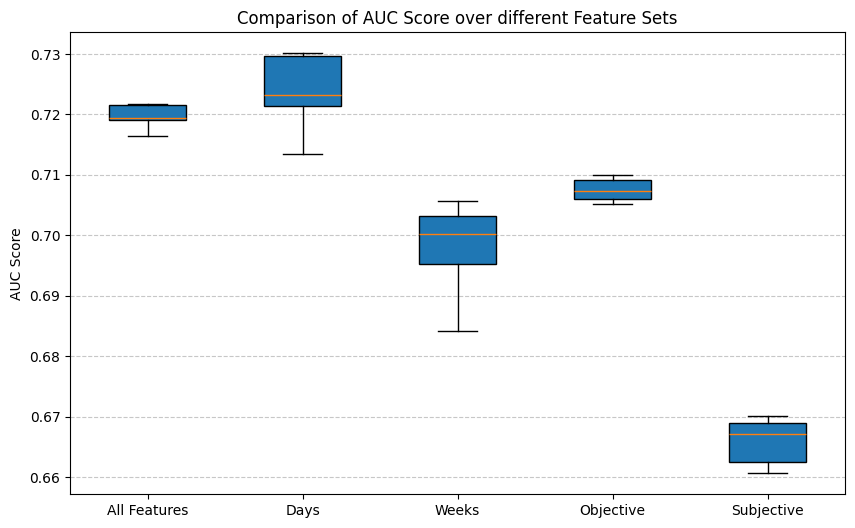

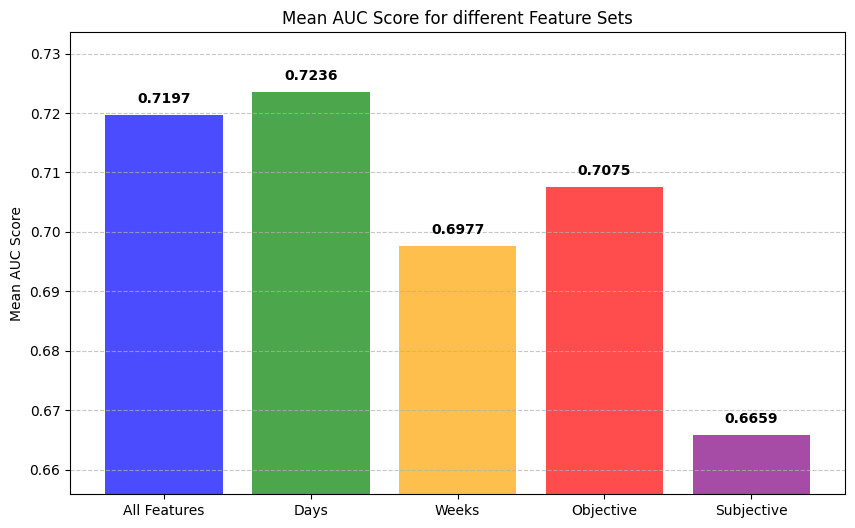

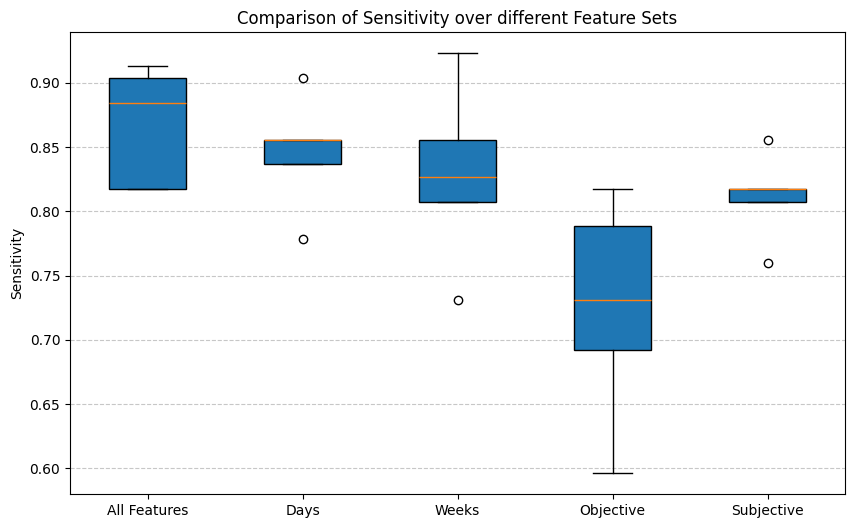

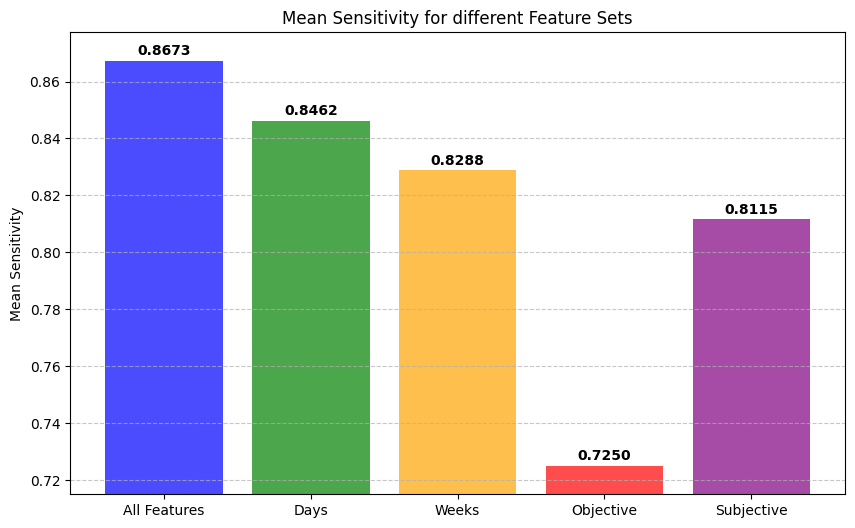

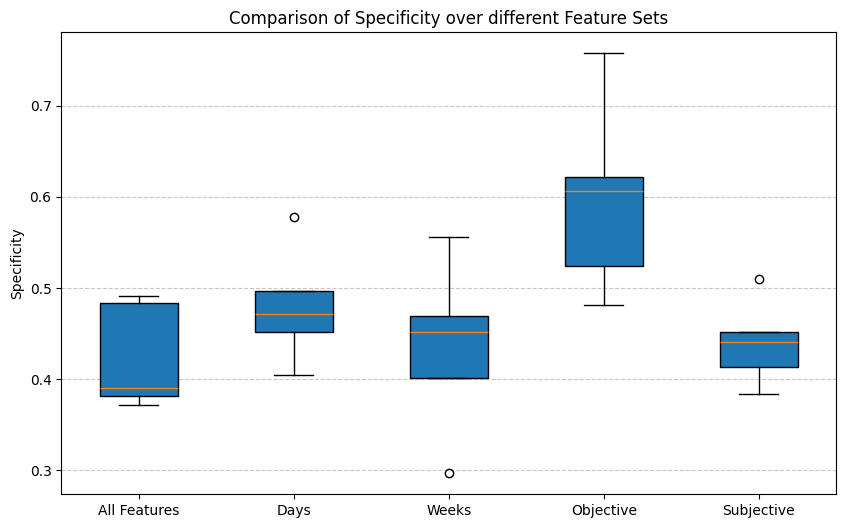

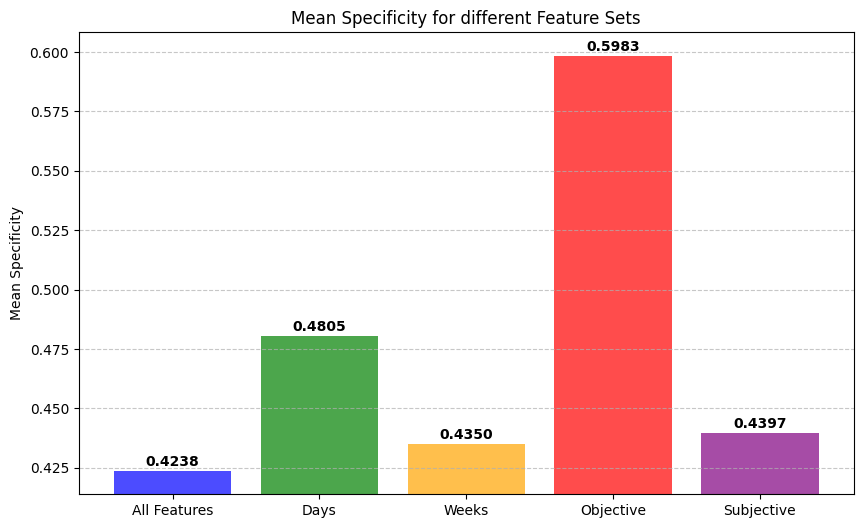

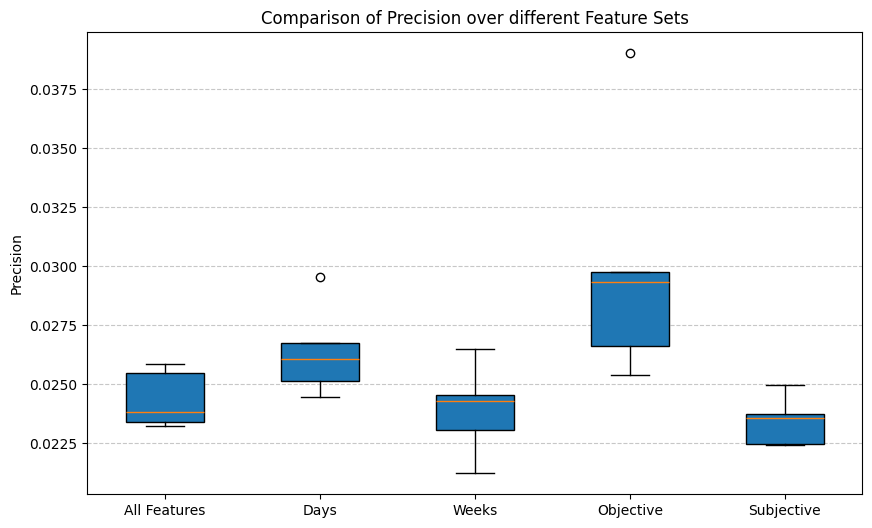

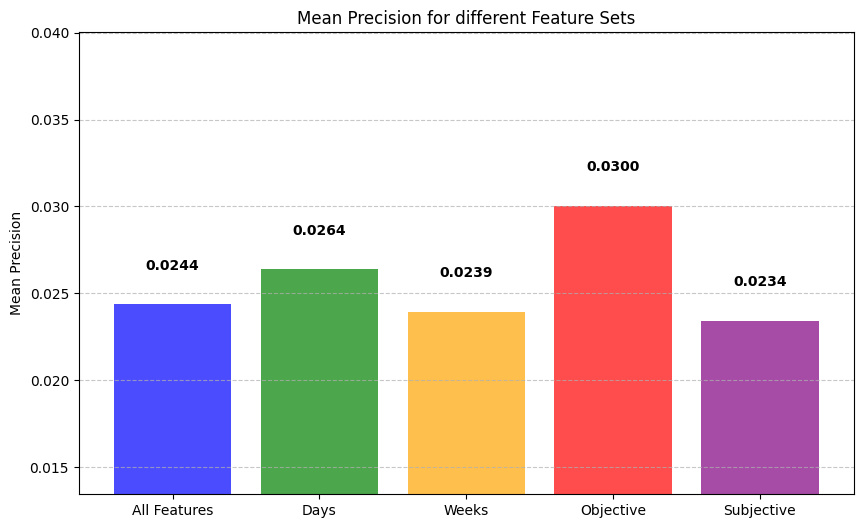

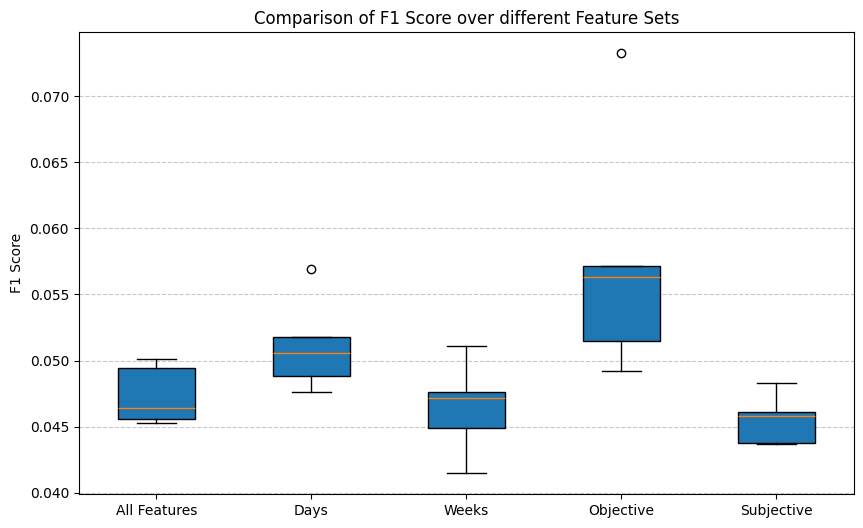

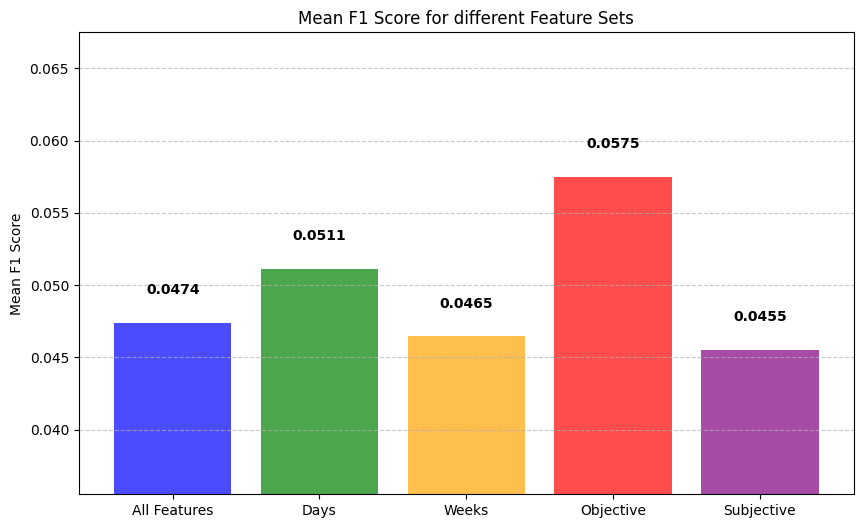

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

feature_set_names = ["All Features", "Days", "Weeks", "Objective", "Subjective"]

# Save all metrics
metrics = {
    "AUC Score": [all_auc_scores, auc_scores_days, auc_scores_weeks, auc_scores_objective, auc_scores_subjective],
    "Sensitivity": [all_sensitivity, sensitivity_days, sensitivity_weeks, sensitivity_objective, sensitivity_subjective],
    "Specificity": [all_specificity, specificity_days, specificity_weeks, specificity_objective, specificity_subjective],
    "Precision": [all_precision, precision_days, precision_weeks, precision_objective, precision_subjective],
    "F1 Score": [all_f1, f1_days, f1_weeks, f1_objective, f1_subjective],
}

# Plots
for metric_name, metric_data in metrics.items():
    plt.figure(figsize=(10, 6))
    plt.boxplot(metric_data, labels=feature_set_names, patch_artist=True)
    plt.ylabel(metric_name)
    plt.title(f"Comparison of {metric_name} over different Feature Sets")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    mean_values = {name: np.mean(values) for name, values in zip(feature_set_names, metric_data)}

    plt.figure(figsize=(10, 6))
    plt.bar(mean_values.keys(), mean_values.values(),
            color=["blue", "green", "orange", "red", "purple"], alpha=0.7)
    plt.ylabel(f"Mean {metric_name}")
    plt.title(f"Mean {metric_name} for different Feature Sets")
    plt.ylim(min(mean_values.values()) - 0.01, max(mean_values.values()) + 0.01)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    for i, v in enumerate(mean_values.values()):
        plt.text(i, v + 0.002, f"{v:.4f}", ha="center", fontsize=10, fontweight="bold")

    plt.show()

# Average Roc Curves over 5 runs
from sklearn.metrics import roc_curve, auc

roc_data = {
    "All Features": (all_y_true, all_y_pred),
    "Days": (y_true_days, y_pred_days),
    "Weeks": (y_true_weeks, y_pred_weeks),
    "Objective": (y_true_objective, y_pred_objective),
    "Subjective": (y_true_subjective, y_pred_subjective),
}

for name, (all_true, all_pred) in roc_data.items():
    tpr_list = []
    auc_list = []
    mean_fpr = np.linspace(0, 1, 100)

    for y_true, y_score in zip(all_true, all_pred):
        fpr, tpr, _ = roc_curve(y_true, y_score)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tpr_list.append(interp_tpr)
        auc_list.append(auc(fpr, tpr))

    mean_tpr = np.mean(tpr_list, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(auc_list)
    std_auc = np.std(auc_list)

    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, color='blue', label=f"{name} (AUC = {mean_auc:.4f} ± {std_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title(f"Average ROC Curve of {name} (n={amount_of_trainings})")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Single model export (only all features since it has the best probabilities overall)
import joblib
joblib.dump(lgbm_models, 'lgbm_models.pkl')

['lgbm_models.pkl']

In [ ]:
# Model export for Ensemble prediction later
import joblib

joblib.dump(lgbm_models, 'lgbm_models.pkl')
joblib.dump(lgbm_models_days, 'lgbm_models_days.pkl')
joblib.dump(lgbm_models_weeks, 'lgbm_models_weeks.pkl')
joblib.dump(lgbm_models_objective, 'lgbm_models_objective.pkl')
joblib.dump(lgbm_models_subjective, 'lgbm_models_subjective.pkl')

['lgbm_models_subjective.pkl']